In [13]:
import pandas as pd
import sys
import pickle
sys.path.append("D:/ryanh/github/ripple_analyses")
from functions import *
from matplotlib import pyplot as plt
import numpy as np
import itertools
from scipy.ndimage import gaussian_filter1d
import multiprocessing
from joblib import Parallel, delayed
import glob as glob
from scipy.stats import poisson,zscore
import seaborn as sns
import matplotlib.ticker as ticker
from scipy.stats import chi2_contingency 
from scipy import signal
from itertools import groupby
from sklearn.linear_model import RANSACRegressor,LinearRegression
from matplotlib.ticker import AutoMinorLocator


In [6]:
tex_fonts = {
#     # Use LaTeX to write all text
#     "text.usetex": True,
    "font.family": "serif",
    # Use 10pt font in plots, to match 10pt font in document
    "axes.labelsize": 10,
    "font.size": 10,
    # Make the legend/label fonts a little smaller
    "legend.fontsize": 8,
    "xtick.labelsize": 8,
    "ytick.labelsize": 8,
    "svg.fonttype": 'none'
}
plt.style.use('seaborn-paper')
plt.rcParams.update(tex_fonts)

%config InlineBackend.figure_format = 'retina'

In [4]:
def get_raster_points(spikes,peak_time):
    ''' 
    create raster centered over each ripple with a 1 second window
    '''
    x = []
    y = []
    for i,r in enumerate(peak_time):
        idx = (spikes> r - .5) & (spikes < r + .5)
        cur_spks = spikes[idx]
        if any(cur_spks):
            x.append(cur_spks - r)
            y.append(np.ones_like(cur_spks)+i)       
    x = list(itertools.chain(*x))
    y = list(itertools.chain(*y))
    return x, y

def get_h0_z_energy(x,y,binsize=0.005,window=30):
     # bin cell into 5ms bins 
    h0_counts, bin_edges = np.histogram(x, bins=np.arange(-0.5,0.5,binsize))
    # normalize into firing rate
    h0 = h0_counts / (len(np.unique(y))*binsize)
    # smooth to get expected firing rate
    hist_smooth = gaussian_filter1d(h0,window)
    # subtract the expected rates and devided by the standard deviation to get z-scored modulation
    z = (h0 - hist_smooth) / np.sqrt(hist_smooth)
    # Calculate the amplitude of the SWR modulation
    swr_energy = np.sqrt(sum(z**2))
    return h0, z, swr_energy, h0_counts

def swr_modulation(spikes,peak_time,session_range,binsize=0.005,window=30):
    '''
        swr modulation cross-correlograms based on Viejo & Peyrache 2020
    '''
    # get observed values
    x, y = get_raster_points(spikes,peak_time)
    
    h0, z, swr_energy, h0_counts = get_h0_z_energy(x,y,binsize=binsize,window=window)
    
    # get null data based on random peak times
    peak_time_null = np.random.uniform(low=session_range[0], high=session_range[1], size=(len(peak_time),))
    x, y = get_raster_points(spikes,peak_time_null)
    
    h0_null, z_null, swr_energy_null, h0_counts_null = get_h0_z_energy(x,y,binsize,window)
    
    return h0, z, swr_energy, h0_counts, h0_null, z_null, swr_energy_null, h0_counts_null

def shuff_spikes(s,session_range,n_shuff=400):
    '''
    shuffles spike train by -+ session duration
    '''
    # find random uniform intervals to shift spike times
    surrogate = np.random.choice(np.arange(-session_range[1],session_range[1]), size=n_shuff,replace=False)
    shuff_spks = []
    for n in surrogate:
        # offset spike times
        new_s = s + n
        # wrap spike times that are outside the range of session
        if np.any(new_s > session_range[1]):
            idx = new_s > session_range[1]
            new_s = np.hstack([new_s[idx] - min(new_s[idx]),new_s[idx==False]])
        elif np.any(new_s < session_range[0]):
            idx = new_s < session_range[0]
            new_s = np.hstack([new_s[idx==False],new_s[idx] + max(new_s) + -n])

        shuff_spks.append(new_s)
    return shuff_spks

def find_consecutive(L,length=4):
    '''
    gives true or false if binary vector L has consective 1s for at 
    least length n (default=4)
    '''
    grouped_L = [(k, sum(1 for i in g)) for k,g in groupby(L)]
    grouped_L

    n_contig = []
    for item in grouped_L:
        if item[0] == 1:
            n_contig.append(item[1])  
    return np.any(np.array(n_contig) >= length)

def surrogate_test(s,h0,session_range,peak_time,conf=95):
    '''
    shuffle methods based on Oliva et al. 2016 to find significant ripple modulation
    of individual units
    '''
    
    shuff_spks = shuff_spikes(s,session_range)

    null = []
    for new_s in shuff_spks:
        x, y = get_raster_points(new_s, peak_time)
        cur_h0, _, _, _ = get_h0_z_energy(x,y)
        null.append(cur_h0)

    null = np.array(null)
    # here I'm using percentiles to get window
    shuff_hibound = np.percentile(null, conf, axis=0) 
    shuff_lobound = np.percentile(null, 100-conf, axis=0)
    
    hi_pass = find_consecutive((h0 > shuff_hibound) * 1)
    low_pass = find_consecutive((h0 < shuff_lobound) * 1)
    
    return hi_pass,low_pass,shuff_hibound,shuff_lobound

def get_participation_prob(s,df_swr):
    '''
    The probability of participation: number of events in which a unit 
    fired at least one spike during the ripple divided by the total
    number of ripples detected.
    '''
    spk_in_range = []
    for event in df_swr.itertuples():
        spk_in_range.append(np.any(((s >= event.start_time) & (s <= event.end_time))))
    
    participation_prob = sum(spk_in_range)/len(df_swr.session)
    
    # find participation prob of long vs short ripples
    long = sum(df_swr.ripple_duration[spk_in_range] > 0.1)
    short = sum(df_swr.ripple_duration[spk_in_range] < 0.1)
    
    if long == 0:
        long = long + np.finfo(float).eps
    if short == 0: 
        short = short + np.finfo(float).eps
        
    lvs = (long - short)/(long + short)
    
    return participation_prob,lvs

def bin_spikes(spike_times,dt,wdw_start,wdw_end):
    """
    Function that puts spikes into bins
    Parameters
    ----------
    spike_times: an array of arrays
        an array of neurons. within each neuron's array is an array containing all the spike times of that neuron
    dt: number (any format)
        size of time bins
    wdw_start: number (any format)
        the start time for putting spikes in bins
    wdw_end: number (any format)
        the end time for putting spikes in bins
    Returns
    -------
    neural_data: a matrix of size "number of time bins" x "number of neurons"
        the number of spikes in each time bin for each neuron
    """
    edges=np.arange(wdw_start,wdw_end,dt) #Get edges of time bins
    num_bins=edges.shape[0]-1 #Number of bins
    num_neurons=spike_times.shape[0] #Number of neurons
    neural_data=np.empty([num_bins,num_neurons]) #Initialize array for binned neural data
    #Count number of spikes in each bin for each neuron, and put in array
    for i in range(num_neurons):
        neural_data[:,i] = np.histogram(spike_times[i],edges)[0]
    return neural_data,edges

def get_sort_index(current_nd):
    location = []
    for r in current_nd.T:
        loc = np.where(r==1)[0]
        if loc.shape[0] == 0:
            location.append(np.nan)
        else:
            location.append(loc[0])
    return np.argsort(location), location

def norm_temp_pos(idx,location):
    x = np.zeros(len(idx))
    i = 0
    for val in idx:
        x[val] = i
        i += 1
    x[np.isnan(location)] = np.nan
    return (x - np.nanmin(x)) / (np.nanmax(x)-np.nanmin(x))

def get_rank_order(spikes,df_swr,session,session_range,dt=0.001):
    """
    Normalized mean rank order based on Fernandez-Ruiz et al., 2019
    """
    # bin spikes
    neural_data,edges = bin_spikes(spikes,dt,session_range[0],session_range[1])
    ts = edges[1:] - dt/2
#     ts = np.arange(session_range[0]+dt/2,session_range[1]-dt/2,dt)
    # make spike binary
    neural_data[neural_data > 0] = 1
    
    # find mean rank order 
    norm_pos = []   
    for event in df_swr[df_swr.session == session].itertuples():
        # pull out neural data for current ripple
        idx = (ts > event.start_time) & (ts < event.end_time)
        current_nd = neural_data[idx,:]
        # sort by rank order
        idx,location = get_sort_index(current_nd)
        # get normalized temporal position (0 to 1)
        norm_pos.append(norm_temp_pos(idx,location)) 

    return np.nanmean(np.array(norm_pos),axis=0)


In [6]:
def main_loop(session,df_swr,data_path,save_path):
    
    base = os.path.basename(session)
    os.path.splitext(base)
    save_file = save_path + os.path.splitext(base)[0] + '.pkl'
    
    # check if saved file exists
    if os.path.exists(save_file):
        return
    
    h0_all = []
    z_all = []
    swr_energy_all = []
    h0_counts_all = []
    
    h0_null_all = []
    z_null_all = []
    swr_energy_null_all = []
    h0_counts_null_all = []
    
    hi_pass_all = []
    low_pass_all = []
    shuff_hibound_all = []
    shuff_lobound_all = []
    
    participation_prob_all = []
    long_v_short_all = []
    
    # find index of first mention of session
    rip_n = np.where(df_swr.session == session)[0][0]
    # load spikes
    spikes = np.load(
        os.path.join('F:/Projects/PAE_PlaceCell/analysis/spikes',
                     df_swr.iloc[rip_n].session+'.npy'),
        allow_pickle=True
    )
    # get ripple times
    peak_time = df_swr.peak_time[df_swr.session == session]
    # get session range
    spikes_ = list(itertools.chain(*spikes))
    session_range = [min(spikes_),max(spikes_)]
    
    # get mean rank order of units
    rank_order = get_rank_order(spikes,df_swr,session,session_range)

    # loop through each cell and get modulation 
    for s in spikes:
        h0, z, swr_energy, h0_counts, h0_null, z_null, swr_energy_null, h0_counts_null = swr_modulation(s,peak_time,session_range)
        hi_pass, low_pass, shuff_hibound, shuff_lobound = surrogate_test(s,h0,session_range,peak_time)

        participation_prob,lvs = get_participation_prob(s,df_swr[df_swr.session == session])
        
        h0_all.append(h0)
        z_all.append(z)
        swr_energy_all.append(swr_energy)
        h0_counts_all.append(h0_counts)

        h0_null_all.append(h0_null)
        z_null_all.append(z_null)
        swr_energy_null_all.append(swr_energy_null)
        h0_counts_null_all.append(h0_counts_null)

        hi_pass_all.append(hi_pass)
        low_pass_all.append(low_pass)
        shuff_hibound_all.append(shuff_hibound)
        shuff_lobound_all.append(shuff_lobound)
        
        participation_prob_all.append(participation_prob)
        long_v_short_all.append(lvs)

    with open(save_file, 'wb') as f:
        pickle.dump(h0_all, f)
        pickle.dump(z_all, f)  
        pickle.dump(swr_energy_all, f)  
        pickle.dump(h0_counts_all, f)  
        pickle.dump(h0_null_all, f)
        pickle.dump(z_null_all, f)  
        pickle.dump(swr_energy_null_all, f) 
        pickle.dump(h0_counts_null_all, f) 
        pickle.dump(hi_pass_all, f)
        pickle.dump(low_pass_all, f)  
        pickle.dump(shuff_hibound_all, f) 
        pickle.dump(shuff_lobound_all, f) 
        pickle.dump(participation_prob_all, f) 
        pickle.dump(long_v_short_all, f) 
        pickle.dump(rank_order, f) 


project_path = 'F:/Projects/PAE_PlaceCell/'
analysis_path = project_path+'analysis/'
data_path = project_path+'ProcessedData/'          
save_path = analysis_path+"ripple_modulation/"
df_swr = pd.read_csv(analysis_path+'swr_data/post_processed/swr_df.csv')
df_cell_class = pd.read_csv(analysis_path+'cell_recruitment/processed/pyr_int_df.csv')

sessions = pd.unique(df_swr.session)

num_cores = multiprocessing.cpu_count()         
processed_list = Parallel(n_jobs=num_cores)(delayed(main_loop)(session,df_swr,data_path,save_path) for session in sessions)


# for session in sessions:
#     print(session)
#     main_loop(session,df_swr,data_path,save_path)

# read back in results per session

In [3]:
project_path = 'F:/Projects/PAE_PlaceCell/'
analysis_path = project_path+'analysis/'
data_path = project_path+'ProcessedData/'          
save_path = analysis_path+"ripple_modulation/"
df_swr = pd.read_csv(analysis_path+'swr_data/post_processed/swr_df.csv')
df_cell_class = pd.read_csv(analysis_path+'cell_recruitment/processed/pyr_int_df.csv')

def load_in_everything(save_path):
    
    sessions = glob.glob(save_path + '*.pkl')
    h0 = []
    z = []
    swr_energy = []
    h0_counts = []

    h0_null = []
    z_null = []
    swr_energy_null = []
    h0_counts_null = []
    
    hi_pass = []
    low_pass = []
    shuff_hibound = []
    shuff_lobound = []
    participation_prob = []
    long_v_short = []
    rank_order = []
    
    mod_dict = {}

    for session in sessions:
        with open(session, 'rb') as f:
            h0.append(pickle.load(f))
            z.append(pickle.load(f))
            swr_energy.append(pickle.load(f))
            h0_counts.append(pickle.load(f))
            h0_null.append(pickle.load(f))
            z_null.append(pickle.load(f))
            swr_energy_null.append(pickle.load(f))
            h0_counts_null.append(pickle.load(f))

            hi_pass.append(pickle.load(f))
            low_pass.append(pickle.load(f))
            shuff_hibound.append(pickle.load(f))
            shuff_lobound.append(pickle.load(f))
            participation_prob.append(pickle.load(f))
            long_v_short.append(pickle.load(f))
            rank_order.append(pickle.load(f))
        
    swr_energy = list(itertools.chain(*swr_energy))
    h0 = np.vstack(h0)
    z = np.vstack(z)
    h0_counts = np.vstack(h0_counts)

    swr_energy_null = list(itertools.chain(*swr_energy_null))
    h0_null = np.vstack(h0_null)
    z_null = np.vstack(z_null)
    h0_counts_null = np.vstack(h0_counts_null)
    
    participation_prob = list(itertools.chain(*participation_prob))
    hi_pass = list(itertools.chain(*hi_pass))
    low_pass = list(itertools.chain(*low_pass))
    shuff_hibound = np.vstack(shuff_hibound)
    shuff_lobound = np.vstack(shuff_lobound)

    long_v_short = list(itertools.chain(*long_v_short))
    rank_order = list(itertools.chain(*rank_order))
    
    mod_dict = {
        "h0": h0,
        "z": z,
        "swr_energy": swr_energy,
        "h0_counts": h0_counts,
        "h0_null": h0_null,
        "z_null": z_null,
        "swr_energy_null": swr_energy_null,
        "h0_counts_null": h0_counts_null,
        "participation_prob": participation_prob,
        "hi_pass": hi_pass,
        "low_pass": low_pass,
        "shuff_hibound": shuff_hibound,
        "shuff_lobound": shuff_lobound,
        "long_v_short" : long_v_short,
        "rank_order": rank_order
    }
    return mod_dict

mod_dict = load_in_everything(save_path)
mod_dict.keys()

dict_keys(['h0', 'z', 'swr_energy', 'h0_counts', 'h0_null', 'z_null', 'swr_energy_null', 'h0_counts_null', 'participation_prob', 'hi_pass', 'low_pass', 'shuff_hibound', 'shuff_lobound', 'long_v_short', 'rank_order'])

### check to see if all data is present

In [4]:
print(df_cell_class.shape)

for item in mod_dict.keys():
    print(item,len(mod_dict[item]))

(8782, 33)
h0 8513
z 8513
swr_energy 8513
h0_counts 8513
h0_null 8513
z_null 8513
swr_energy_null 8513
h0_counts_null 8513
participation_prob 8513
hi_pass 8513
low_pass 8513
shuff_hibound 8513
shuff_lobound 8513
long_v_short 8513
rank_order 8513


# Add metrics to df

In [ ]:
# metrics from analysis
df_cell_class['swr_energy'] = mod_dict['swr_energy']
df_cell_class['participation_prob'] = mod_dict['participation_prob']
df_cell_class['hi_pass'] = mod_dict['hi_pass']
df_cell_class['low_pass'] = mod_dict['low_pass']
df_cell_class['long_v_short'] = mod_dict['long_v_short']
df_cell_class['rank_order'] = mod_dict['rank_order']

# add rat
rat = [s.split('_')[0] for s in df_cell_class.session]
df_cell_class['rat']=rat

# group
control=('RH13','RH14','LS21','LS23','LE2821','LE2823','LEM3116','LEM3120','LEM3216')
pae=('RH11','RH16','LS17','LS19','LE2813','LEM3124','LEM3206','LEM3246')

df_cell_class['group'] = np.ones_like(df_cell_class.session)

regstr = '|'.join(control)
idx = df_cell_class['session'].str.upper().str.contains(regstr)    
df_cell_class.loc[idx,'group'] = 'control'

regstr = '|'.join(pae)
idx = df_cell_class['session'].str.upper().str.contains(regstr)    
df_cell_class.loc[idx,'group'] = 'pae'

# number of ripples 
n_ripples = [sum(df_swr.session == session) for session in df_cell_class.session]
df_cell_class['n_ripples'] = n_ripples

# number of spikes in the 1 second window around ripples
n_spikes_in_rip_window = [cch.sum() for cch in mod_dict['h0_counts']] 
df_cell_class['n_spikes_in_rip_window'] = n_spikes_in_rip_window

# zscore tuning curves
from scipy import stats
mod_dict['h0_zscore'] = stats.zscore(mod_dict['h0'],axis=1)

# ripple strength, absolute value mean of the center 3 bins
center_idx = int(mod_dict['h0_zscore'].shape[1]/2)
df_cell_class['mod_strength'] = np.abs(np.mean(mod_dict['h0_zscore'][:,center_idx-1:center_idx+2],axis=1))

### restrict to HPC

In [8]:
idx = (df_cell_class['area'] == 'ca1') | (df_cell_class['area'] == 'ca3')

for item in mod_dict.keys():
    print(item)
    mod_dict[item] = np.array(mod_dict[item])[idx]
    
df_cell_class = df_cell_class[idx]

h0
z
swr_energy
h0_counts
h0_null
z_null
swr_energy_null
h0_counts_null
participation_prob
hi_pass
low_pass
shuff_hibound
shuff_lobound
long_v_short
rank_order
h0_zscore


In [60]:
df_cell_class.to_csv(r'F:\Projects\PAE_PlaceCell\analysis\ripple_modulation\post_processed\pyr_int_df.csv')

In [61]:
f = open(r'F:\Projects\PAE_PlaceCell\analysis\ripple_modulation\post_processed\mod_dict.pkl',"wb")
pickle.dump(mod_dict,f)
f.close()

In [2]:
df_cell_class = pd.read_csv(r'F:\Projects\PAE_PlaceCell\analysis\ripple_modulation\post_processed\pyr_int_df.csv')
df_cell_class.head()

,Unnamed: 0,Unnamed: 0.1,session,tetrode,cell,acg_tau_decay,acg_tau_rise,acg_c,acg_d,acg_asymptote,...,participation_prob,hi_pass,low_pass,long_v_short,rank_order,rat,group,n_ripples,n_spikes_in_rip_window,mod_strength
0,0,0,LEM3116_S20180715121821,TT1.mat,1,31.546309,0.573929,7.484840,1.810424,4.267133,...,0.818182,False,False,0.777778,0.557696,LEM3116,control,11,63,0.562410
1,1,1,LEM3116_S20180715121821,TT1.mat,2,2.066006,2.058184,99.344603,1.086215,2.731016,...,0.000000,False,False,0.000000,NaN,LEM3116,control,11,20,0.267980
2,2,2,LEM3116_S20180715121821,TT2.mat,1,26.506166,0.781068,15.805209,1.504109,4.955974,...,0.909091,False,False,0.600000,0.456941,LEM3116,control,11,101,0.675589
3,3,3,LEM3116_S20180715121821,TT3.mat,1,4.712647,3.339123,44.065945,3.111166,0.573573,...,0.090909,False,False,1.000000,0.818182,LEM3116,control,11,2,0.100759
4,4,4,LEM3116_S20180715121821,TT3.mat,2,69.711440,1.119072,2.272114,4.029701,6.440918,...,0.000000,False,False,0.000000,NaN,LEM3116,control,11,9,0.217643


## convolution method of finding sig peaks or troughs

don't run... relying on the shuffle analysis for now
 

In [ ]:
# def local_firfilt( x, W ):
#     C = int(len(W))
#     D = int(np.ceil(C / 2) - 1)
#     xx = [np.flipud(x[:C]), x, np.flipud(x[-C:])]
#     xx = list(itertools.chain(*xx))
#     Y = signal.lfilter(W,1,xx)
#     Y = Y[C + D : len(Y) - C + D]
#     return Y

# def local_gausskernel(sigma,N):
#     x = np.arange(-(N-1) / 2, ((N-1) / 2) + 1)
#     k = 1 / (2*np.pi*sigma) * np.exp(-(x**2 / 2 / sigma**2 ))
#     return k

# def cch_conv(cch,W=30,HF=0.6):
#     # Stark and Abeles JNM 2009
#     SDG = W / 2
#     if round(SDG)==SDG: # even W
#         win = local_gausskernel(SDG, 6 * SDG + 1)
#         cidx = int(SDG * 3 + 1)
#     else:
#         win = local_gausskernel(SDG, 6 * SDG + 2) 
#         cidx = int(SDG * 3 + 1.5)
#     win[cidx-1] = win[cidx-1] * ( 1 - HF )
#     win = win / sum( win )
#     pred = local_firfilt( cch, win )
#     pvals = 1 - poisson.cdf(cch - 1, pred) - poisson.pmf(cch, pred) * 0.5
#     qvals = 1 - pvals
#     return pvals, pred, qvals

# def sig_mod(cch,binsize=0.005,sig_window=0.2,alpha=0.001,W=30):
#     # check and correct for negative values
#     if np.any(cch<0):
#         cch = cch + np.abs(min(cch))
    
#     pvals, pred, qvals = cch_conv(cch,W)

#     nBonf = int(sig_window/binsize)*2;
#     hiBound = poisson.ppf(1-alpha/nBonf, pred)
#     loBound = poisson.ppf(alpha/nBonf, pred)

#     center_bins = np.arange(int(len(cch)/2 - .1/binsize), int(len(cch)/2 + .1/binsize))
#     # at least 2 bins more extreme than bound to be sig
#     sig = (sum(cch[center_bins] > max(hiBound))>2) | (sum(cch[center_bins] < min(loBound))>2)
#     return sig, hiBound, loBound, pvals, pred

# # sig, hiBound, loBound, pvals, pred = sig_mod(hist,alpha=0.05)
# sig, hiBound, loBound, pvals, pred = zip(*[sig_mod(cch,alpha=0.05) for cch in mod_dict['z']])
# df_cell_class['sig_center'] = sig

In [9]:
idx = (df_cell_class.n_ripples >= 100) & (df_cell_class.n_spikes >= 100) & ((df_cell_class.hi_pass == True) | (df_cell_class.low_pass == True))
# temp_df = df_cell_class[idx]

np.sum(idx)

1232

# Ripple modulation figure

In [13]:
import matplotlib as mpl

class MidpointNormalize(mpl.colors.Normalize):
    '''
    https://stackoverflow.com/questions/7404116/defining-the-midpoint-of-a-colormap-in-matplotlib
    '''
    def __init__(self, vmin, vmax, midpoint=0, clip=False):
        self.midpoint = midpoint
        mpl.colors.Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        normalized_min = max(0, 1 / 2 * (1 - abs((self.midpoint - self.vmin) / (self.midpoint - self.vmax))))
        normalized_max = min(1, 1 / 2 * (1 + abs((self.vmax - self.midpoint) / (self.midpoint - self.vmin))))
        normalized_mid = 0.5
        x, y = [self.vmin, self.midpoint, self.vmax], [normalized_min, normalized_mid, normalized_max]
        return np.ma.masked_array(np.interp(value, x, y))
    
def confidence_intervals(X,conf=0.95):
    # remove nans
    X = X[np.sum(np.isnan(X),axis=1) == 0,:]
    # compute interval for each column
    interval = [stats.t.interval(conf, len(a) - 1, loc = np.mean(a), scale = stats.sem(a)) for a in X.T]
    interval = np.vstack(interval)
    lower = interval[:,0]
    upper = interval[:,1]
    return lower,upper       

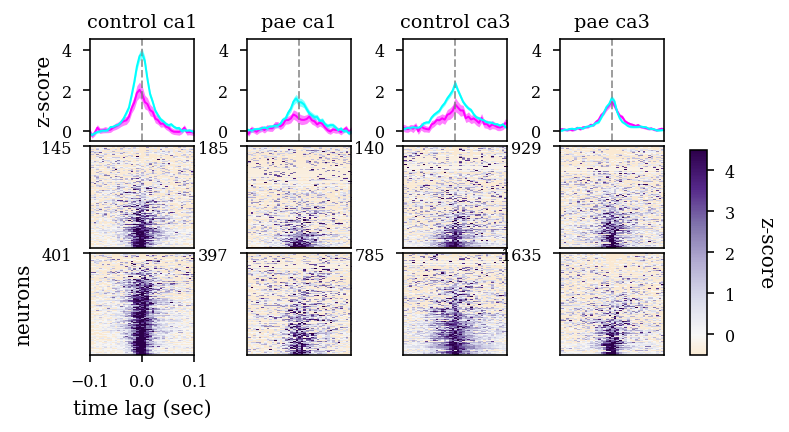

In [11]:
n_ripples = 50
n_spikes = 100

good_cells = ((df_cell_class.n_ripples >= n_ripples) &
              (df_cell_class.n_spikes >= n_spikes))

def plot_mod_matrix(df_cell_class,mod_dict,good_cells,group,area,cell_type,ax,x_off=False):
    norm = MidpointNormalize(vmin=-0.5, vmax=4.5, midpoint=0)

    h0_current = mod_dict['h0_zscore'][good_cells &
                           (df_cell_class.cell_type == cell_type) &
                           (df_cell_class.area == area) &
                           (df_cell_class.group == group)]
    # get and sort by mean of center 3 columns
    center_idx = int(h0_current.shape[1]/2)
    idx = np.mean(h0_current[:,center_idx-1:center_idx+2],axis=1)
    idx = np.argsort(idx)
    # get x axis
    extent = [-.5 , .5, 0 , len(idx)]
    # plot matrix
    ax.imshow(h0_current[idx,:],aspect='auto',extent=extent,cmap=plt.get_cmap('PuOr'),norm=norm)
    # restrict to +-100ms
    ax.set_xlim(-0.1,0.1)
    ax.set_yticks([h0_current.shape[0]])
    if x_off:
        ax.axes.get_xaxis().set_ticks([])
    
def plot_mod_mean_std(df_cell_class,mod_dict,good_cells,group,area,cell_type,ax,color):
    h0_current = mod_dict['h0_zscore'][good_cells &
                       (df_cell_class.cell_type == cell_type) &
                       (df_cell_class.area == area) &
                       (df_cell_class.group == group)]
    x = np.linspace(-.5,.5,mod_dict['h0'].shape[1]) 
    m = np.nanmean(h0_current,axis=0)
    
#     v = np.nanstd(h0_current,axis=0) / np.sqrt(h0_current.shape[0])
    lower,upper = confidence_intervals(h0_current)
    
    ax.plot(x,m, color = color, linewidth = 1)
#     ax.fill_between(x, m-v, m+v, color = color, alpha = 0.5, linewidth = 0)
    ax.fill_between(x, lower, upper, color = color, alpha = 0.5, linewidth = 0)
    ax.axvline(0, linestyle = '--', linewidth = 1, alpha = 0.5, color = 'grey')
    ax.set_title(group+' '+area)
    ax.set_xlim(-0.1,0.1)
    ax.set_ylim(-.5,4.5)
    ax.axes.get_xaxis().set_ticks([])
    

fig, axs = plt.subplots(3,4, figsize=set_size('thesis', fraction=1, subplots=(3,4)), edgecolor='k')
fig.subplots_adjust(hspace = .05, wspace=.5)
ax = axs.ravel()  

cmap = plt.get_cmap("cool_r",2)

plot_mod_mean_std(df_cell_class,mod_dict,good_cells,'control','ca1','int',ax[0],cmap(0))
ax[0].set_ylabel('z-score')

plot_mod_mean_std(df_cell_class,mod_dict,good_cells,'control','ca1','pyr',ax[0],cmap(1))

plot_mod_mean_std(df_cell_class,mod_dict,good_cells,'pae','ca1','int',ax[1],cmap(0))
plot_mod_mean_std(df_cell_class,mod_dict,good_cells,'pae','ca1','pyr',ax[1],cmap(1))

plot_mod_mean_std(df_cell_class,mod_dict,good_cells,'control','ca3','int',ax[2],cmap(0))
plot_mod_mean_std(df_cell_class,mod_dict,good_cells,'control','ca3','pyr',ax[2],cmap(1))

plot_mod_mean_std(df_cell_class,mod_dict,good_cells,'pae','ca3','int',ax[3],cmap(0))
plot_mod_mean_std(df_cell_class,mod_dict,good_cells,'pae','ca3','pyr',ax[3],cmap(1))


plot_mod_matrix(df_cell_class,mod_dict,good_cells,'control','ca1','int',ax[4],True)
plot_mod_matrix(df_cell_class,mod_dict,good_cells,'control','ca1','pyr',ax[8])
ax[8].set_xlabel('time lag (sec)')
ax[8].set_ylabel('neurons')

plot_mod_matrix(df_cell_class,mod_dict,good_cells,'pae','ca1','int',ax[5],True)
plot_mod_matrix(df_cell_class,mod_dict,good_cells,'pae','ca1','pyr',ax[9],True)

plot_mod_matrix(df_cell_class,mod_dict,good_cells,'control','ca3','int',ax[6],True)
plot_mod_matrix(df_cell_class,mod_dict,good_cells,'control','ca3','pyr',ax[10],True)

plot_mod_matrix(df_cell_class,mod_dict,good_cells,'pae','ca3','int',ax[7],True)
plot_mod_matrix(df_cell_class,mod_dict,good_cells,'pae','ca3','pyr',ax[11],True)

import matplotlib as mpl

norm = MidpointNormalize(vmin=-0.5, vmax=4.5, midpoint=0)

# norm = mpl.colors.Normalize(vmin=-0.5, vmax=4.5)
sm = plt.cm.ScalarMappable(cmap=plt.get_cmap('PuOr'), norm=norm)
sm.set_array([])
plt.subplots_adjust(bottom=0.1, right=0.8, top=0.9)
cax = plt.axes([0.83, 0.1, 0.02, 0.52])
cbar = plt.colorbar(sm,cax=cax)
cbar.set_label('z-score', rotation=270, labelpad=20)
# cbar.outline.set_visible(False)

plt.savefig(r'D:\ryanh\GoogleDrive\school_work\UNM\Lab\Projects\Dissertation\dissertation\inkscape_figs\ripple_recuitment\fr_mod.svg',dpi=300,bbox_inches='tight')


# Proportion of modulated cells

In [12]:
good_cells = ((df_cell_class.n_ripples >= 50) &
              (df_cell_class.n_spikes >= 100))
pd.unique(df_cell_class.rat[good_cells])


array(['LEM3116', 'LEM3120', 'LEM3124', 'LEM3206', 'LEM3216', 'LEM3246',
       'LS19', 'LS23'], dtype=object)

In [5]:
df_cell_class['ripple_mod'] = (df_cell_class.hi_pass == True) | (df_cell_class.low_pass == True)


In [14]:
group = []
area = []
cell_type = []
prop = []

idx = (df_cell_class.group=='control') & (df_cell_class.area=='ca1') & (df_cell_class.cell_type=='int')
group.append('control')
area.append('ca1')
cell_type.append('int')
prop.append(sum(df_cell_class.ripple_mod[good_cells & idx]) / len(df_cell_class.ripple_mod[good_cells & idx]))

idx = (df_cell_class.group=='control') & (df_cell_class.area=='ca1') & (df_cell_class.cell_type=='pyr')
group.append('control')
area.append('ca1')
cell_type.append('pyr')
prop.append(sum(df_cell_class.ripple_mod[good_cells & idx]) / len(df_cell_class.ripple_mod[good_cells & idx]))

idx = (df_cell_class.group=='control') & (df_cell_class.area=='ca3') & (df_cell_class.cell_type=='int')
group.append('control')
area.append('ca3')
cell_type.append('int')
prop.append(sum(df_cell_class.ripple_mod[good_cells & idx]) / len(df_cell_class.ripple_mod[good_cells & idx]))

idx = (df_cell_class.group=='control') & (df_cell_class.area=='ca3') & (df_cell_class.cell_type=='pyr')
group.append('control')
area.append('ca3')
cell_type.append('pyr')
prop.append(sum(df_cell_class.ripple_mod[good_cells & idx]) / len(df_cell_class.ripple_mod[good_cells & idx]))


idx = (df_cell_class.group=='pae') & (df_cell_class.area=='ca1') & (df_cell_class.cell_type=='int')
group.append('pae')
area.append('ca1')
cell_type.append('int')
prop.append(sum(df_cell_class.ripple_mod[good_cells & idx]) / len(df_cell_class.ripple_mod[good_cells & idx]))

idx = (df_cell_class.group=='pae') & (df_cell_class.area=='ca1') & (df_cell_class.cell_type=='pyr')
group.append('pae')
area.append('ca1')
cell_type.append('pyr')
prop.append(sum(df_cell_class.ripple_mod[good_cells & idx]) / len(df_cell_class.ripple_mod[good_cells & idx]))

idx = (df_cell_class.group=='pae') & (df_cell_class.area=='ca3') & (df_cell_class.cell_type=='int')
group.append('pae')
area.append('ca3')
cell_type.append('int')
prop.append(sum(df_cell_class.ripple_mod[good_cells & idx]) / len(df_cell_class.ripple_mod[good_cells & idx]))

idx = (df_cell_class.group=='pae') & (df_cell_class.area=='ca3') & (df_cell_class.cell_type=='pyr')
group.append('pae')
area.append('ca3')
cell_type.append('pyr')
prop.append(sum(df_cell_class.ripple_mod[good_cells & idx]) / len(df_cell_class.ripple_mod[good_cells & idx]))


d = {'group': group, 'area': area, 'cell_type': cell_type, 'prop': prop }
df2 = pd.DataFrame(data=d)

df2

,group,area,cell_type,prop
0,control,ca1,int,0.386207
1,control,ca1,pyr,0.690773
2,control,ca3,int,0.192857
3,control,ca3,pyr,0.439490
4,pae,ca1,int,0.183784
5,pae,ca1,pyr,0.224181
6,pae,ca3,int,0.276642
7,pae,ca3,pyr,0.288685


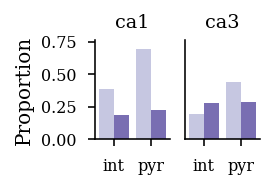

In [15]:
f, ax = plt.subplots(1,2,figsize=set_size('thesis', fraction=0.25, subplots=(1, 1)))
fig.subplots_adjust(hspace = 0, wspace=0)
ax = ax.ravel()

max_value = 0.76

sns.set_palette(sns.color_palette('Purples',2))
sns.barplot(x="cell_type", y="prop",hue = "group", data=df2[df2.area=='ca1'],ax=ax[0],saturation=1,alpha=1)

ax[0].legend([],[], frameon=False)
ax[0].set(ylabel="Proportion")
# sns.despine(trim=False, left=True)
ax[0].set_ylim(0,max_value)
ax[0].set_title('ca1')
ax[0].set_xlabel('')
ax[0].set_yticks(np.arange(0,max_value,.25))


sns.set_palette(sns.color_palette('Purples',2))
g = sns.barplot(x="cell_type", y="prop",hue = "group", data=df2[df2.area=='ca3'],ax=ax[1],saturation=1,alpha=1)
ax[1].legend([],[], frameon=False)
ax[1].set(ylabel="Proportion")
ax[1].axes.get_yaxis().set_ticks([])
ax[1].set_ylabel('')
ax[1].set_xlabel('')
ax[1].set_ylim(0,max_value)
ax[1].set_title('ca3')
# ax[1].spines["left"].set_visible(False)
sns.despine(trim=False, right=True)

plt.savefig(r'D:\ryanh\GoogleDrive\school_work\UNM\Lab\Projects\Dissertation\dissertation\inkscape_figs\ripple_recuitment\proportions.svg',dpi=300,bbox_inches='tight')


## get prop of pyr/int units per session

...however some rats have tetrodes in multipe areas in a recording so the proportion will need to be calculated on the basis of each area instead of each session


In [19]:
temp_df.keys()

Index(['Unnamed: 0', 'Unnamed: 0.1', 'session', 'tetrode', 'cell',
       'acg_tau_decay', 'acg_tau_rise', 'acg_c', 'acg_d', 'acg_asymptote',
       'acg_refrac', 'acg_tau_burst', 'acg_h', 'acg_fit_rsquare',
       'thetaModulationIndex', 'burstIndex_Royer2012', 'burstIndex_Doublets',
       'polarity', 'peaktoTrough', 'troughtoPeak', 'derivative_TroughtoPeak',
       'peakA', 'peakB', 'ab_ratio', 'trough', 'spkW', 'short_isi', 'lv', 'cv',
       'avg_fr', 'asymmetry', 'n_spikes', 'cell_type', 'area', 'swr_energy',
       'participation_prob', 'hi_pass', 'low_pass', 'long_v_short',
       'rank_order', 'rat', 'group', 'n_ripples', 'n_spikes_in_rip_window',
       'mod_strength', 'session_area'],
      dtype='object')

In [6]:
def add_group_affiliation(df):
    control=('RH13','RH14','LS21','LS23','LE2821','LE2823','LEM3116','LEM3120','LEM3216')
    pae=('RH11','RH16','LS17','LS19','LE2813','LEM3124','LEM3206','LEM3246')

    df['group'] = np.ones_like(df.session)

    regstr = '|'.join(control)
    idx = df['session'].str.upper().str.contains(regstr)    
    df.loc[idx, "group"] = 'control'

    regstr = '|'.join(pae)
    idx = df['session'].str.upper().str.contains(regstr)    
    df.loc[idx, "group"] = 'pae'
    return df

good_cells = ((df_cell_class.n_ripples >= 50) &
              (df_cell_class.n_spikes >= 100) & 
              ((df_cell_class.area=='ca1') | (df_cell_class.area=='ca3')))
temp_df = df_cell_class[good_cells]

# get combo of session and area because one rat as tetrodes in multiple areas
temp_df['session_area'] = temp_df.session+temp_df.area

n_pyr = []
n_int = []
prop_pyr = []
prop_int = []
# loop through each unique session/area id
for session in pd.unique(temp_df.session_area):
    n_pyr.append(sum(temp_df.cell_type[temp_df.session_area == session] == 'pyr')+np.finfo(float).eps)
    n_int.append(sum(temp_df.cell_type[temp_df.session_area == session] == 'int')+np.finfo(float).eps)

    n_pyr_pass = sum((temp_df.session_area == session) & (temp_df.cell_type=='pyr') & (temp_df.ripple_mod == 1))
    prop_pyr.append(n_pyr_pass / n_pyr[-1])

    n_int_pass = sum((temp_df.session_area == session) & (temp_df.cell_type=='int') & (temp_df.ripple_mod == 1))
    prop_int.append(n_int_pass / n_int[-1])
    

df_prop = pd.DataFrame()

df_prop['session'] = pd.unique(temp_df.session_area)

rat = [s.split('_')[0] for s in df_prop.session]
df_prop['rat']=rat
df_prop = add_group_affiliation(df_prop)
df_prop['area'] = df_prop.session.map(lambda x: str(x)[-3:])
df_prop['session'] = df_prop.session.map(lambda x: str(x)[:-3])

df_prop['prop_pyr'] = prop_pyr
df_prop['prop_int'] = prop_int

df_prop['n_pyr'] = n_pyr
df_prop['n_int'] = n_int

df_prop.n_int = pd.to_numeric(df_prop.n_int, downcast='integer')
df_prop.n_pyr = pd.to_numeric(df_prop.n_pyr, downcast='integer')

display(df_prop.head())

df_prop.to_csv('F:/Projects/PAE_PlaceCell/analysis/ripple_modulation/post_processed/df_prop.csv')


<ipython-input-6-3ebd32906a18>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_df['session_area'] = temp_df.session+temp_df.area


,session,rat,group,area,prop_pyr,prop_int,n_pyr,n_int
0,LEM3116_S20180717110938,LEM3116,control,ca1,0.674699,0.666667,83,24
1,LEM3116_S20180718184628,LEM3116,control,ca1,0.300000,0.000000,20,0
2,LEM3116_S20180802100324,LEM3116,control,ca3,0.196078,0.000000,51,8
3,LEM3116_S20180803103321,LEM3116,control,ca3,0.156863,0.000000,51,11
4,LEM3116_S20180806104145,LEM3116,control,ca3,0.236364,0.055556,55,18


In [56]:
df_prop.n_pyr.max()

92

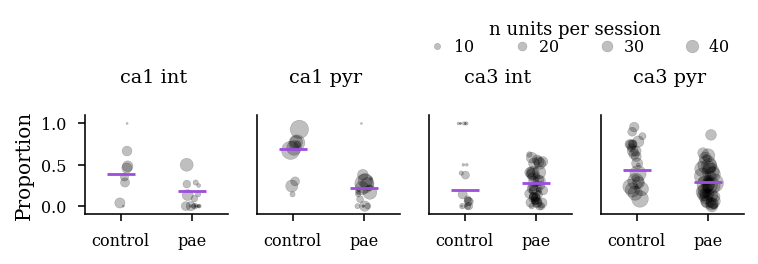

In [78]:
def weighted_average_m1(distribution, weights):
    return sum([distribution[i]*weights[i] for i in range(len(distribution))])/sum(weights)

def plot_prop_custom(df_prop,y_name,w_name,ax):
    x = (df_prop.group == 'pae') * 1 + (np.random.randint(-100,100,len(df_prop))*.001)

    y = df_prop[y_name]
    h = ax.scatter(
        x,y,
        color='k',
        alpha=.25,
        s=df_prop[w_name]
    )
    
    mean = weighted_average_m1(
        np.array(df_prop[(df_prop.group=='control')][y_name]),
        np.array(df_prop[(df_prop.group=='control')][w_name])
    )
    ax.scatter(0,mean,marker="_",color='#9d4edd',s=200)
    
    mean = weighted_average_m1(
        np.array(df_prop[(df_prop.group=='pae')][y_name]),
        np.array(df_prop[(df_prop.group=='pae')][w_name])
    )
    ax.scatter(1,mean,marker="_",color='#9d4edd',s=200)
    
    ax.set_xlim(-.5,1.5)
    ax.set_xticks([0,1])
    ax.set_xticklabels(['control','pae'])
    return h
        
fig, ax = plt.subplots(1,4,figsize=set_size('thesis', fraction=1, subplots=(1, 4)))
fig.subplots_adjust(hspace = .5, wspace=.2)
ax = ax.ravel()

plot_prop_custom(df_prop[df_prop.area=='ca1'],'prop_int','n_int',ax[0])
plot_prop_custom(df_prop[df_prop.area=='ca1'],'prop_pyr','n_pyr',ax[1])
h0 = plot_prop_custom(df_prop[df_prop.area=='ca3'],'prop_int','n_int',ax[2])
plot_prop_custom(df_prop[df_prop.area=='ca3'],'prop_pyr','n_pyr',ax[3])

handles, labels = h0.legend_elements(num=5,prop="sizes", alpha=0.25)
# legend2 = ax[3].legend(handles, labels,loc='upper right', bbox_to_anchor=(1.2, 1, 0.5, 0.5), title="n units",frameon=False)
legend2 = ax[3].legend(handles,
                       labels,
                       ncol=4,
                       loc='upper right',
                       bbox_to_anchor=(0.5, 1.6, 0.5, 0.5),
                       title="n units per session",
                       frameon=False,
                       fontsize=8,
                       labelspacing=0,
                       handletextpad=0)

plt.setp(legend2.get_title(),fontsize=9)

ax[0].set_title('ca1 int \n')
ax[1].set_title('ca1 pyr \n')
ax[2].set_title('ca3 int \n')
ax[3].set_title('ca3 pyr \n')

ax[0].set(xlabel="")
sns.despine(trim=False, right=True)

ax[0].set_ylim(-.1,1.1)
ax[1].set_ylim(-.1,1.1)
ax[2].set_ylim(-.1,1.1)
ax[3].set_ylim(-.1,1.1)

ax[0].set_ylabel('Proportion')
ax[1].set_ylabel('')
ax[2].set_ylabel('')
ax[3].set_ylabel('')

ax[1].axes.get_yaxis().set_ticks([])
ax[2].axes.get_yaxis().set_ticks([])
ax[3].axes.get_yaxis().set_ticks([])


plt.savefig(r'D:\ryanh\GoogleDrive\school_work\UNM\Lab\Projects\Dissertation\dissertation\inkscape_figs\ripple_recuitment\rip_mod_prop_per_session_v2.svg',dpi=300,bbox_inches='tight')


# format data for group comparison

In [16]:
# n_pyr = []
# n_pyr_pass = []
# n_int = []
# n_int_pass = []
# area = []
# curr_session = []

# good_cells = ((df_cell_class.n_ripples >= 50) &
#               (df_cell_class.n_spikes >= 100))
# temp_df = df_cell_class[good_cells]


# for session in pd.unique(temp_df.session):
    
#     sess_idx = temp_df.session == session
#     if sum(temp_df.area[sess_idx] == 'ca1') == len(temp_df.area[sess_idx]):
#         n_pyr.append(sum((sess_idx) & (temp_df.cell_type=='pyr')))
#         n_pyr_pass.append(sum((sess_idx) & (temp_df.cell_type=='pyr') & (temp_df.ripple_mod == 1)))

#         n_int.append(sum((sess_idx) & (temp_df.cell_type=='int')))
#         n_int_pass.append(sum((sess_idx) & (temp_df.cell_type=='int') & (temp_df.ripple_mod == 1)))
        
#         area.append('ca1')
#         curr_session.append(session)

#     elif sum(temp_df.area[sess_idx] == 'ca3') == len(temp_df.area[sess_idx]):
#         n_pyr.append(sum((sess_idx) & (temp_df.cell_type=='pyr')))
#         n_pyr_pass.append(sum((sess_idx) & (temp_df.cell_type=='pyr') & (temp_df.ripple_mod == 1)))

#         n_int.append(sum((sess_idx) & (temp_df.cell_type=='int')))
#         n_int_pass.append(sum((sess_idx) & (temp_df.cell_type=='int') & (temp_df.ripple_mod == 1)))
        
#         area.append('ca3')
#         curr_session.append(session)

#     else:
#         n_pyr.append(sum((sess_idx) & (temp_df.cell_type=='pyr')))
#         n_pyr_pass.append(sum((sess_idx) & (temp_df.cell_type=='pyr') & (temp_df.ripple_mod == 1)))

#         n_int.append(sum((sess_idx) & (temp_df.cell_type=='int')))
#         n_int_pass.append(sum((sess_idx) & (temp_df.cell_type=='int') & (temp_df.ripple_mod == 1)))
        
#         area.append('ca1')
#         curr_session.append(session)

#         n_pyr.append(sum((sess_idx) & (temp_df.cell_type=='pyr')))
#         n_pyr_pass.append(sum((sess_idx) & (temp_df.cell_type=='pyr') & (temp_df.ripple_mod == 1)))

#         n_int.append(sum((sess_idx) & (temp_df.cell_type=='int')))
#         n_int_pass.append(sum((sess_idx) & (temp_df.cell_type=='int') & (temp_df.ripple_mod == 1)))
        
#         area.append('ca3')
#         curr_session.append(session)


In [ ]:
# df_prop = pd.DataFrame()

# df_prop['n_pyr'] = n_pyr
# df_prop['n_pyr_pass'] = n_pyr_pass
# df_prop['n_int'] = n_int
# df_prop['n_int_pass'] = n_int_pass
# df_prop['area'] = area
# df_prop['session'] = curr_session

# control=('RH13','RH14','LS21','LS23','LE2821','LE2823','LEM3116','LEM3120','LEM3216')
# pae=('RH11','RH16','LS17','LS19','LE2813','LEM3124','LEM3206','LEM3246')

# df_prop['group'] = np.ones_like(df_prop.session)

# regstr = '|'.join(control)
# idx = df_prop['session'].str.upper().str.contains(regstr)    
# df_prop.loc[idx,'group'] = 'control'

# regstr = '|'.join(pae)
# idx = df_prop['session'].str.upper().str.contains(regstr)    
# df_prop.loc[idx,'group'] = 'pae'

# rat = [s.split('_')[0] for s in df_prop.session]
# df_prop['rat']=rat

# display(df_prop)

# df_prop.to_csv('F:/Projects/PAE_PlaceCell/analysis/ripple_modulation/post_processed/df_prop.csv')


In [18]:
# df_prop['prop_pyr'] = df_prop.n_pyr_pass / df_prop.n_pyr

# df_prop['prop_int'] = df_prop.n_int_pass / df_prop.n_int


In [ ]:
# fig, ax = plt.subplots(1,4,figsize=set_size('thesis', fraction=1, subplots=(1, 4)))
# fig.subplots_adjust(hspace = 0, wspace=0.1)
# ax = ax.ravel()

# sns.set_palette(sns.color_palette('Purples',2))

# sns.boxplot(x="group", y="prop_int", data=df_prop[df_prop.area=='ca1'],
#             whis=[0, 100], width=.6,ax=ax[0],saturation=1)
# sns.stripplot(x="group", y="prop_int",data=df_prop[df_prop.area=='ca1'],
#               size=3, color="k",alpha=.5, linewidth=0,ax=ax[0])
# ax[0].set_title('ca1 int')


# sns.boxplot(x="group", y="prop_pyr", data=df_prop[df_prop.area=='ca1'],
#             whis=[0, 100], width=.6,ax=ax[1],saturation=1)
# sns.stripplot(x="group", y="prop_pyr",data=df_prop[df_prop.area=='ca1'],
#               size=3, color="k",alpha=.5, linewidth=0,ax=ax[1])
# ax[1].set_title('ca1 pyr')


# sns.boxplot(x="group", y="prop_int", data=df_prop[df_prop.area=='ca3'],
#             whis=[0, 100], width=.6,ax=ax[2],saturation=1)
# sns.stripplot(x="group", y="prop_int",data=df_prop[df_prop.area=='ca3'],
#               size=3, color="k",alpha=.5, linewidth=0,ax=ax[2])
# ax[2].set_title('ca3 int')


# sns.boxplot(x="group", y="prop_pyr", data=df_prop[df_prop.area=='ca3'],
#             whis=[0, 100], width=.6,ax=ax[3],saturation=1)
# sns.stripplot(x="group", y="prop_pyr",data=df_prop[df_prop.area=='ca3'],
#               size=3, color="k",alpha=.5, linewidth=0,ax=ax[3])
# ax[3].set_title('ca3 pyr')


# ax[0].set(xlabel="")
# sns.despine(trim=False, right=True)


# ax[0].set_ylim(0,1)
# ax[1].set_ylim(0,1)
# ax[2].set_ylim(0,1)
# ax[3].set_ylim(0,1)

# ax[0].set_xlabel('')
# ax[1].set_xlabel('')
# ax[2].set_xlabel('')
# ax[3].set_xlabel('')

# ax[0].set_ylabel('Proportion')
# ax[1].set_ylabel('')
# ax[2].set_ylabel('')
# ax[3].set_ylabel('')

# ax[1].axes.get_yaxis().set_ticks([])
# ax[2].axes.get_yaxis().set_ticks([])
# ax[3].axes.get_yaxis().set_ticks([])

# plt.savefig(r'D:\ryanh\GoogleDrive\school_work\UNM\Lab\Projects\Dissertation\dissertation\inkscape_figs\ripple_recuitment\rip_mod_prop_per_session.svg',dpi=300,bbox_inches='tight')


# Participation probability 

Text(0, 0.5, 'baseline firing rate (Hz)')

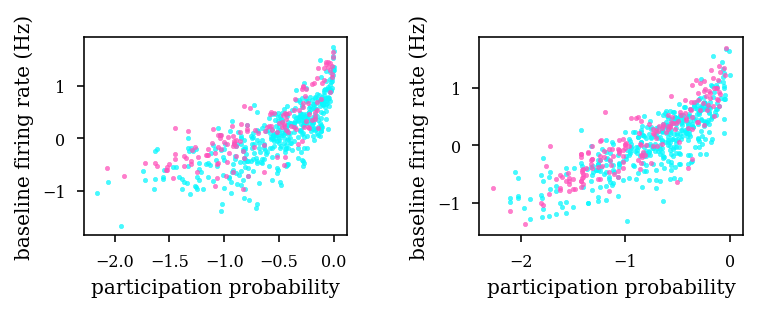

In [24]:
fig, ax = plt.subplots(1,2,figsize=set_size('thesis', fraction=1, subplots=(1, 2)))
fig.subplots_adjust(hspace = 0, wspace=.5)
ax = ax.ravel()

idx = (df_cell_class.cell_type == 'pyr') & good_cells & (df_cell_class.group == "control") & (df_cell_class.area == "ca1")
ax[0].scatter(np.log10(df_cell_class.participation_prob)[idx],np.log10(df_cell_class.avg_fr)[idx],s=5,color='#08F7FE',alpha=.75)

idx = (df_cell_class.cell_type == 'int') & good_cells & (df_cell_class.group == "control") & (df_cell_class.area == "ca1")
ax[0].scatter(np.log10(df_cell_class.participation_prob)[idx],np.log10(df_cell_class.avg_fr)[idx],s=5,color='#FE53BB',alpha=.75)
ax[0].set_xlabel('participation probability')
ax[0].set_ylabel('baseline firing rate (Hz)')


idx = (df_cell_class.cell_type == 'pyr') & good_cells & (df_cell_class.group == "pae") & (df_cell_class.area == "ca1")
ax[1].scatter(np.log10(df_cell_class.participation_prob)[idx],np.log10(df_cell_class.avg_fr)[idx],s=5,color='#08F7FE',alpha=.75)

idx = (df_cell_class.cell_type == 'int') & good_cells & (df_cell_class.group == "pae") & (df_cell_class.area == "ca1")
ax[1].scatter(np.log10(df_cell_class.participation_prob)[idx],np.log10(df_cell_class.avg_fr)[idx],s=5,color='#FE53BB',alpha=.75)
ax[1].set_xlabel('participation probability')
ax[1].set_ylabel('baseline firing rate (Hz)')

# long verse short duration ripple probability

In [25]:
df_cell_class.keys()

Index(['Unnamed: 0', 'session', 'tetrode', 'cell', 'acg_tau_decay',
       'acg_tau_rise', 'acg_c', 'acg_d', 'acg_asymptote', 'acg_refrac',
       'acg_tau_burst', 'acg_h', 'acg_fit_rsquare', 'thetaModulationIndex',
       'burstIndex_Royer2012', 'burstIndex_Doublets', 'polarity',
       'peaktoTrough', 'troughtoPeak', 'derivative_TroughtoPeak', 'peakA',
       'peakB', 'ab_ratio', 'trough', 'spkW', 'short_isi', 'lv', 'cv',
       'avg_fr', 'asymmetry', 'n_spikes', 'cell_type', 'area', 'swr_energy',
       'participation_prob', 'hi_pass', 'low_pass', 'long_v_short',
       'rank_order', 'rat', 'group', 'n_ripples', 'n_spikes_in_rip_window',
       'mod_strength', 'ripple_mod'],
      dtype='object')

Text(0, 0.5, 'baseline firing rate (Hz)')

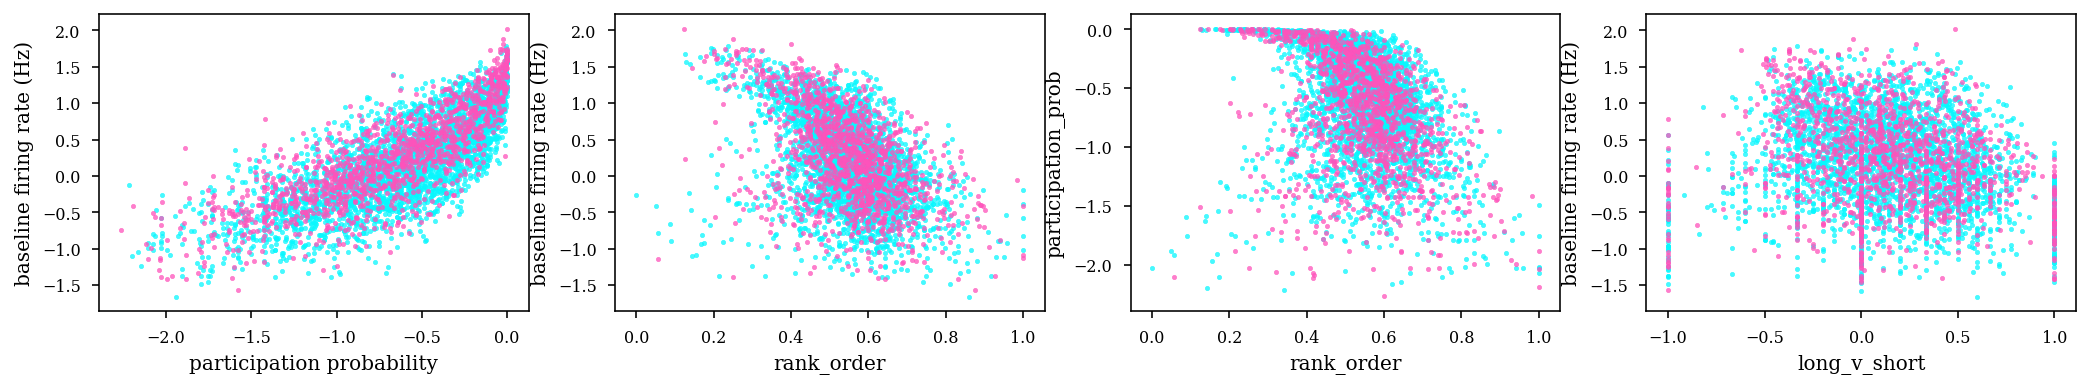

In [26]:
f, ax = plt.subplots(1,4,figsize=set_size('thesis', fraction=3, subplots=(1, 4)))
fig.subplots_adjust(hspace = 5, wspace=5)
ax = ax.ravel()

idx = (df_cell_class.cell_type == 'pyr') & good_cells
ax[0].scatter(np.log10(df_cell_class.participation_prob)[idx],np.log10(df_cell_class.avg_fr)[idx],s=5,color='#08F7FE',alpha=.75)

idx = (df_cell_class.cell_type == 'int') & good_cells
ax[0].scatter(np.log10(df_cell_class.participation_prob)[idx],np.log10(df_cell_class.avg_fr)[idx],s=5,color='#FE53BB',alpha=.75)
ax[0].set_xlabel('participation probability')
ax[0].set_ylabel('baseline firing rate (Hz)')


idx = (df_cell_class.cell_type == 'pyr') & good_cells
ax[1].scatter(df_cell_class.rank_order[idx],np.log10(df_cell_class.avg_fr)[idx],s=5,color='#08F7FE',alpha=.75)

idx = (df_cell_class.cell_type == 'int') & good_cells
ax[1].scatter(df_cell_class.rank_order[idx],np.log10(df_cell_class.avg_fr)[idx],s=5,color='#FE53BB',alpha=.75)
ax[1].set_xlabel('rank_order')
ax[1].set_ylabel('baseline firing rate (Hz)')


idx = (df_cell_class.cell_type == 'pyr') & good_cells
ax[2].scatter(df_cell_class.rank_order[idx],np.log10(df_cell_class.participation_prob)[idx],s=5,color='#08F7FE',alpha=.75)

idx = (df_cell_class.cell_type == 'int') & good_cells
ax[2].scatter(df_cell_class.rank_order[idx],np.log10(df_cell_class.participation_prob)[idx],s=5,color='#FE53BB',alpha=.75)
ax[2].set_xlabel('rank_order')
ax[2].set_ylabel('participation_prob')



idx = (df_cell_class.cell_type == 'pyr') & good_cells
ax[3].scatter(df_cell_class.long_v_short[idx],np.log10(df_cell_class.avg_fr)[idx],s=5,color='#08F7FE',alpha=.75)

idx = (df_cell_class.cell_type == 'int') & good_cells
ax[3].scatter(df_cell_class.long_v_short[idx],np.log10(df_cell_class.avg_fr)[idx],s=5,color='#FE53BB',alpha=.75)
ax[3].set_xlabel('long_v_short')
ax[3].set_ylabel('baseline firing rate (Hz)')

D:\ryanh\Anaconda3\envs\ripple_analysis\lib\site-packages\pandas\core\series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


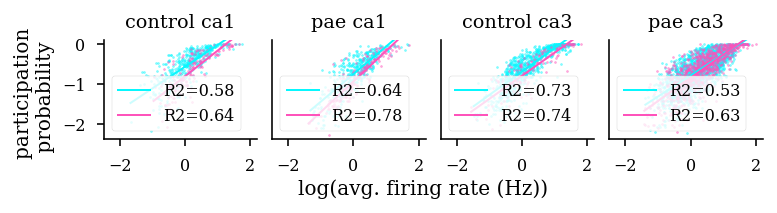

In [23]:

def get_slope_intercept(X,y):
    # remove infs and nans
    idx = np.isinf(X) | np.isinf(y) | np.isnan(X) | np.isnan(y) 
    
    X = np.array(X)
    y = np.array(y)
    
    X = X[~(idx)]
    y = y[~(idx)]
    reg = LinearRegression().fit(X.reshape(-1, 1),y.reshape(-1, 1))
#     reg = RANSACRegressor().fit(X.reshape(-1, 1),y.reshape(-1, 1))
    xaxis = np.arange(X.min(), X.max(), 0.01)
    yaxis = reg.predict(xaxis.reshape((len(xaxis), 1)))
    r2 = reg.score(X.reshape(-1, 1),y.reshape(-1, 1))
    return xaxis,yaxis,r2,reg

def plot_feature(feature_1,feature_2,df_cell_class,good_cells,area,group,cell_type,color,ax):
    idx = good_cells & (df_cell_class.area == area) & (df_cell_class.group == group) & (df_cell_class.cell_type == cell_type)
    X = df_cell_class[feature_1][idx]
    y = df_cell_class[feature_2][idx]
    idx = np.isinf(X) | np.isinf(y) | np.isnan(X) | np.isnan(y) 
    X = np.array(X)
    y = np.array(y)
    X = X[~(idx)]
    y = y[~(idx)]
    ax.scatter(X,y,s=1,alpha=.5,color=color,rasterized=True)
#     slope,intercept = get_slope_intercept(X,y)
#     ax.plot(X,(slope* X + intercept),linewidth=1,color=color)
    xaxis,yaxis,r2,reg = get_slope_intercept(X,y)
    ax.plot(xaxis,yaxis,linewidth=1,color=color,label=('R2='+str(round(r2, 2))))
    return reg

fig, axs = plt.subplots(1,4, figsize=set_size('thesis', fraction=1, subplots=(1, 4)), edgecolor='k')
fig.subplots_adjust(hspace = .5, wspace=.1)
ax = axs.ravel()

idx = ((df_cell_class.n_ripples >= 50) &
       (df_cell_class.n_spikes >= 100))

df_cell_class['avg_fr_log'] = np.log10(df_cell_class.avg_fr)
df_cell_class['participation_prob_log'] = np.log10(df_cell_class.participation_prob)

plot_feature('avg_fr_log','participation_prob_log',df_cell_class,idx,'ca1','control','pyr','#08F7FE',ax[0])
plot_feature('avg_fr_log','participation_prob_log',df_cell_class,idx,'ca1','control','int','#FE53BB',ax[0])
# ax[0].axes.get_xaxis().set_ticks([])
ax[0].set_title('control ca1')


plot_feature('avg_fr_log','participation_prob_log',df_cell_class,idx,'ca3','control','pyr','#08F7FE',ax[2])
plot_feature('avg_fr_log','participation_prob_log',df_cell_class,idx,'ca3','control','int','#FE53BB',ax[2])
# ax[2].set_xlabel('>short ripple > long ripple')
# ax[2].set_ylabel('baseline \n firing rate (Hz)')
ax[2].axes.get_yaxis().set_ticks([])

ax[2].set_title('control ca3')


plot_feature('avg_fr_log','participation_prob_log',df_cell_class,idx,'ca1','pae','pyr','#08F7FE',ax[1])
plot_feature('avg_fr_log','participation_prob_log',df_cell_class,idx,'ca1','pae','int','#FE53BB',ax[1])
# ax[1].axes.get_xaxis().set_ticks([])
ax[1].axes.get_yaxis().set_ticks([])
ax[1].set_title('pae ca1')


plot_feature('avg_fr_log','participation_prob_log',df_cell_class,idx,'ca3','pae','pyr','#08F7FE',ax[3])
plot_feature('avg_fr_log','participation_prob_log',df_cell_class,idx,'ca3','pae','int','#FE53BB',ax[3])
ax[3].axes.get_yaxis().set_ticks([])
# ax[3].axes.get_xaxis().set_ticks([])
ax[3].set_title('pae ca3')


x = df_cell_class.avg_fr_log
x_min = min(x[(np.isinf(x) | np.isnan(x))==False])
x_max = max(x[(np.isinf(x) | np.isnan(x))==False])

ax[0].set_xlim(x_min,x_max)
ax[1].set_xlim(x_min,x_max)
ax[2].set_xlim(x_min,x_max)
ax[3].set_xlim(x_min,x_max)

y = df_cell_class.participation_prob_log
y_min = min(y[(np.isinf(y) | np.isnan(y))==False])-.1
y_max = max(y[(np.isinf(y) | np.isnan(y))==False])+.1

ax[0].set_ylim(y_min,y_max)
ax[1].set_ylim(y_min,y_max)
ax[2].set_ylim(y_min,y_max)
ax[3].set_ylim(y_min,y_max)

ax[0].legend()
ax[1].legend()
ax[2].legend()
ax[3].legend()
for i in range(4):
    ax[i].spines['top'].set_visible(False)
    ax[i].spines['right'].set_visible(False)
    
    
fig.text(0.5,-.3, 'log(avg. firing rate (Hz))', ha='center')
fig.text(0.02, 0.5, 'participation \n probability', va='center', rotation='vertical')

plt.savefig(r'D:\ryanh\GoogleDrive\school_work\UNM\Lab\Projects\Dissertation\dissertation\inkscape_figs\ripple_recuitment\fr_prob.svg',dpi=300,bbox_inches='tight')


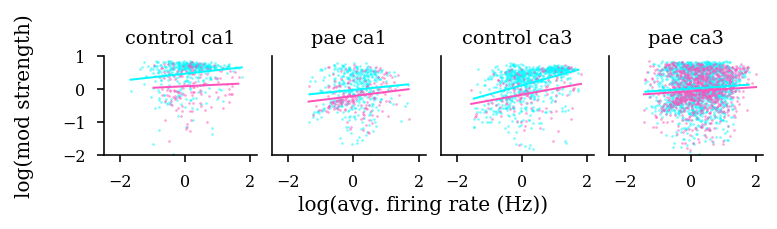

In [155]:
fig, axs = plt.subplots(1,4, figsize=set_size('thesis', fraction=1, subplots=(1, 4)), edgecolor='k')
fig.subplots_adjust(hspace = .5, wspace=.1)
ax = axs.ravel()

idx = ((df_cell_class.n_ripples >= 50) &
       (df_cell_class.n_spikes >= 100))

df_cell_class['avg_fr_log'] = np.log10(df_cell_class.avg_fr)
df_cell_class['mod_strength_log'] = np.log10(df_cell_class.mod_strength)

plot_feature('avg_fr_log','mod_strength_log',df_cell_class,idx,'ca1','control','pyr','#08F7FE',ax[0])
plot_feature('avg_fr_log','mod_strength_log',df_cell_class,idx,'ca1','control','int','#FE53BB',ax[0])
# ax[0].axes.get_xaxis().set_ticks([])
ax[0].set_title('control ca1')


plot_feature('avg_fr_log','mod_strength_log',df_cell_class,idx,'ca3','control','pyr','#08F7FE',ax[2])
plot_feature('avg_fr_log','mod_strength_log',df_cell_class,idx,'ca3','control','int','#FE53BB',ax[2])
# ax[2].set_xlabel('>short ripple > long ripple')
# ax[2].set_ylabel('baseline \n firing rate (Hz)')
ax[2].axes.get_yaxis().set_ticks([])

ax[2].set_title('control ca3')


plot_feature('avg_fr_log','mod_strength_log',df_cell_class,idx,'ca1','pae','pyr','#08F7FE',ax[1])
plot_feature('avg_fr_log','mod_strength_log',df_cell_class,idx,'ca1','pae','int','#FE53BB',ax[1])
# ax[1].axes.get_xaxis().set_ticks([])
ax[1].axes.get_yaxis().set_ticks([])
ax[1].set_title('pae ca1')


plot_feature('avg_fr_log','mod_strength_log',df_cell_class,idx,'ca3','pae','pyr','#08F7FE',ax[3])
plot_feature('avg_fr_log','mod_strength_log',df_cell_class,idx,'ca3','pae','int','#FE53BB',ax[3])
ax[3].axes.get_yaxis().set_ticks([])
# ax[3].axes.get_xaxis().set_ticks([])
ax[3].set_title('pae ca3')


x = df_cell_class.avg_fr_log
x_min = min(x[(np.isinf(x) | np.isnan(x))==False])
x_max = max(x[(np.isinf(x) | np.isnan(x))==False])

ax[0].set_xlim(x_min,x_max)
ax[1].set_xlim(x_min,x_max)
ax[2].set_xlim(x_min,x_max)
ax[3].set_xlim(x_min,x_max)

y = df_cell_class.mod_strength_log
y_min = min(y[(np.isinf(y) | np.isnan(y))==False])
y_max = max(y[(np.isinf(y) | np.isnan(y))==False])

ax[0].set_ylim(-2,1)
ax[1].set_ylim(-2,1)
ax[2].set_ylim(-2,1)
ax[3].set_ylim(-2,1)

# ax[0].legend()
# ax[1].legend()
# ax[2].legend()
# ax[3].legend()
for i in range(4):
    ax[i].spines['top'].set_visible(False)
    ax[i].spines['right'].set_visible(False)
    
    
fig.text(0.5,-.3, 'log(avg. firing rate (Hz))', ha='center')
fig.text(0.02, 0.5, 'log(mod strength)', va='center', rotation='vertical')

plt.savefig(r'D:\ryanh\GoogleDrive\school_work\UNM\Lab\Projects\Dissertation\dissertation\inkscape_figs\ripple_recuitment\avg_fr_mod_strength.svg',dpi=300,bbox_inches='tight')


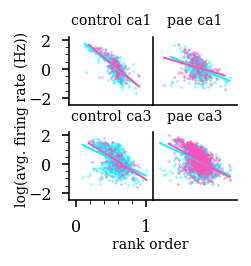

In [27]:
fig, axs = plt.subplots(2,2, figsize=(1.5,1.5), edgecolor='k')

# fig, axs = plt.subplots(2,2, figsize=set_size('thesis', fraction=.45, subplots=(1, 1)), edgecolor='k')
fig.subplots_adjust(hspace = .4, wspace=0)
ax = axs.ravel()

idx = ((df_cell_class.n_ripples >= 50) &
       (df_cell_class.n_spikes >= 100))

reg_ca1_control_pyr = plot_feature('rank_order','avg_fr_log',df_cell_class,idx,'ca1','control','pyr','#08F7FE',ax[0])
reg_ca1_control_int = plot_feature('rank_order','avg_fr_log',df_cell_class,idx,'ca1','control','int','#FE53BB',ax[0])
ax[0].axes.get_xaxis().set_ticks([])
ax[0].set_title('control ca1',fontsize=7)


reg_ca3_control_pyr= plot_feature('rank_order','avg_fr_log',df_cell_class,idx,'ca3','control','pyr','#08F7FE',ax[2])
reg_ca3_control_int = plot_feature('rank_order','avg_fr_log',df_cell_class,idx,'ca3','control','int','#FE53BB',ax[2])
# ax[2].set_xlabel('>short ripple > long ripple')
# ax[2].set_ylabel('baseline \n firing rate (Hz)')
ax[2].set_title('control ca3',fontsize=7)


reg_ca1_pae_pyr = plot_feature('rank_order','avg_fr_log',df_cell_class,idx,'ca1','pae','pyr','#08F7FE',ax[1])
reg_ca1_pae_int = plot_feature('rank_order','avg_fr_log',df_cell_class,idx,'ca1','pae','int','#FE53BB',ax[1])
ax[1].axes.get_xaxis().set_ticks([])
ax[1].axes.get_yaxis().set_ticks([])
ax[1].set_title('pae ca1',fontsize=7)


reg_ca3_pae_pyr = plot_feature('rank_order','avg_fr_log',df_cell_class,idx,'ca3','pae','pyr','#08F7FE',ax[3])
reg_ca3_pae_int = plot_feature('rank_order','avg_fr_log',df_cell_class,idx,'ca3','pae','int','#FE53BB',ax[3])
ax[3].axes.get_yaxis().set_ticks([])
ax[3].axes.get_xaxis().set_ticks([])
ax[3].set_title('pae ca3',fontsize=7)


ax[0].set_xlim(-.1,1.1)
ax[1].set_xlim(-.1,1.1)
ax[2].set_xlim(-.1,1.1)
ax[3].set_xlim(-.1,1.1)


ax[0].set_ylim(min(df_cell_class.avg_fr_log),max(df_cell_class.avg_fr_log))
ax[1].set_ylim(min(df_cell_class.avg_fr_log),max(df_cell_class.avg_fr_log))
ax[2].set_ylim(min(df_cell_class.avg_fr_log),max(df_cell_class.avg_fr_log))
ax[3].set_ylim(min(df_cell_class.avg_fr_log),max(df_cell_class.avg_fr_log))

ax[0].xaxis.set_minor_locator(AutoMinorLocator())
ax[1].xaxis.set_minor_locator(AutoMinorLocator())
ax[2].xaxis.set_minor_locator(AutoMinorLocator())
ax[3].xaxis.set_minor_locator(AutoMinorLocator())
               
ax[0].yaxis.set_minor_locator(AutoMinorLocator())
ax[1].yaxis.set_minor_locator(AutoMinorLocator())
ax[2].yaxis.set_minor_locator(AutoMinorLocator())
ax[3].yaxis.set_minor_locator(AutoMinorLocator())
# ax[0].legend()
# ax[1].legend()
# ax[2].legend()
# ax[3].legend()

for i in range(4):
    ax[i].spines['top'].set_visible(False)
    ax[i].spines['right'].set_visible(False)

fig.text(0.5,-.1, 'rank order', ha='center',fontsize=7)
fig.text(-.13, 0.5, 'log(avg. firing rate (Hz))', va='center', rotation='vertical',fontsize=7)

plt.savefig(r'D:\ryanh\GoogleDrive\school_work\UNM\Lab\Projects\pae_ripple_paper\inkscape_figs\ripple_recuitment\rank_order.svg',dpi=300,bbox_inches='tight')


In [29]:
print(reg_ca1_control_pyr.coef_)
print(reg_ca1_control_int.coef_)
print(reg_ca3_control_pyr.coef_)
print(reg_ca3_control_int.coef_)
print(reg_ca1_pae_pyr.coef_)
print(reg_ca1_pae_int.coef_)
print(reg_ca3_pae_pyr.coef_)
print(reg_ca3_pae_int.coef_)

[[-3.83763035]]
[[-4.00930415]]
[[-2.35281665]]
[[-3.07211871]]
[[-1.96658478]]
[[-1.4203698]]
[[-2.21867225]]
[[-2.63989879]]


# recruitment example figure

In [32]:
session = 'LEM3206_S20190718143924'

# find index of first mention of session
rip_n = np.where(df_swr.session == session)[0][0]
# load spikes
spikes = get_spikes(data_path+df_swr.iloc[rip_n].session+'.mat')
# get ripple times
peak_time = df_swr.peak_time[df_swr.session == session]
# get session range
spikes_ = list(itertools.chain(*spikes))
session_range = [min(spikes_),max(spikes_)]

def get_good_channels(shank):
    #extract values from dictionary
    an_array = np.array(list(shank.values()),dtype=object)
    
    #loop through array to pull out individual channel        
    good_ch = []
    for i in range(len(an_array)):
        for x in range(len(an_array[i])):
            good_ch.append(an_array[i][x])
        
    return good_ch

path = get_session_path(data_path+session+'.mat')

# load xml which has channel & fs info
channels,fs,shank = loadXML(path)

# get good channels
good_ch = get_good_channels(shank)

lfp,lfp_ts = loadLFP(glob.glob(path +'\*.lfp')[0], n_channels=channels,
                 channel=good_ch, frequency=fs)

dt = 0.001
neural_data,edges = bin_spikes(spikes,dt,session_range[0],session_range[1])
ts = edges[1:] - dt/2
neural_data[neural_data > 0] = 1

df_cell_class_all = pd.read_csv('F:/Projects/PAE_PlaceCell/analysis/cell_recruitment/processed/pyr_int_df.csv')
cell_type = df_cell_class_all.cell_type[df_cell_class_all.session == session]

In [33]:
event = df_swr[df_swr.session == session].iloc[5]

# get cell order
idx = (ts > event.start_time) & (ts < event.end_time)
current_nd = neural_data[idx,:]
# sort by rank order
cell_order,location = get_sort_index(current_nd)
# get normalized temporal position (0 to 1)
# norm_pos = norm_temp_pos(cell_order,location)

# get color for cell types
colors = []
for item in cell_type.iloc[cell_order]:
    if item=="pyr": 
        colors.append('#08F7FE')
    else:
        colors.append('#FE53BB')
        
start = event.start_time - 0.1
end = event.end_time + 0.1

# current spikes
current_spikes = []
for s in spikes:
    current_spikes.append(s[(s > start) & (s < end)])
    
spikes_ = list(itertools.chain(*current_spikes))

# current lfp
current_lfp = lfp[(lfp_ts > start) & (lfp_ts < end),event.peak_channel]
current_lfp_ts = lfp_ts[(lfp_ts > start) & (lfp_ts < end)]

<ipython-input-34-8560cfdf2911>:12: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  ax[1].eventplot(np.array(current_spikes)[cell_order],color=colors,linewidths=2,linelengths =1.5)


Text(0.5, 0, 'time (sec)')

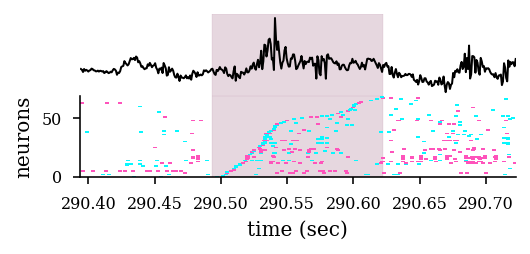

In [34]:
w,l = set_size('thesis', fraction=1, subplots=(1, 1))

fig, axs = plt.subplots(2,1, figsize=(w - 2,1.5), edgecolor='k')
fig.subplots_adjust(hspace = 0, wspace=0)
ax = axs.ravel()

ax[0].plot(current_lfp_ts,current_lfp,'k',linewidth=1)
ax[0].set_xlim(start,end)
ax[0].axvspan(event.start_time, event.end_time, alpha=0.2, color='#843b62', zorder=-1000)
ax[0].axis('off')

ax[1].eventplot(np.array(current_spikes)[cell_order],color=colors,linewidths=2,linelengths =1.5)
ax[1].set_ylim(-.5,len(location)-sum(np.isnan(location)))

ax[1].axvspan(event.start_time, event.end_time, alpha=0.2, color='#843b62', zorder=-1000)
ax[1].set_xlim(start,end)

ax[1].spines['top'].set_visible(False)
ax[1].spines['right'].set_visible(False)

ax[1].set_ylabel('neurons')
ax[1].set_xlabel('time (sec)')

plt.savefig(r'D:\ryanh\GoogleDrive\school_work\UNM\Lab\Projects\Dissertation\dissertation\inkscape_figs\ripple_recuitment\trace_example.svg',dpi=300,bbox_inches='tight')


In [35]:
del lfp

# plot example raster 

In [495]:
session = "LEM3216_S20190805141510"
# find index of first mention of session
rip_n = np.where(df_swr.session == session)[0][0]
# load spikes
spikes = get_spikes(data_path+df_swr.iloc[rip_n].session+'.mat')
# get ripple times
peak_time = df_swr.peak_time[df_swr.session == session]

# [3,7]

In [496]:
session = "LEM3216_S20190726184722"
# find index of first mention of session
rip_n = np.where(df_swr.session == session)[0][0]
# load spikes
spikes = get_spikes(data_path+df_swr.iloc[rip_n].session+'.mat')
# get ripple times
peak_time = df_swr.peak_time[df_swr.session == session]

# [3,7]

In [497]:
display(df_cell_class[df_cell_class.session == session])


,Unnamed: 0,session,tetrode,cell,acg_tau_decay,acg_tau_rise,acg_c,acg_d,acg_asymptote,acg_refrac,...,low_pass,group,n_ripples,n_spikes_in_rip_window,rat,ripple_mod,long_v_short,rank_order,avg_fr_log,participation_prob_log
5759,5759,LEM3216_S20190726184722,TT12.mat,114,14.280731,1.650094,33.970543,1.273633,1.494107,2.982883,...,False,control,121,302,LEM3216,False,0.583333,0.673983,-0.009633,-0.401544
5760,5760,LEM3216_S20190726184722,TT13.mat,116,43.005424,2.226676,14.264352,2.045781,11.560390,3.478937,...,False,control,121,2713,LEM3216,True,0.362832,0.346997,1.138747,-0.029707
5761,5761,LEM3216_S20190726184722,TT13.mat,118,15.076087,0.822647,55.617175,0.860821,12.858982,4.358054,...,False,control,121,1360,LEM3216,True,0.540230,0.529830,0.822217,-0.143266
5762,5762,LEM3216_S20190726184722,TT13.mat,167,22.567979,0.902132,55.646196,1.227709,6.879878,3.427456,...,False,control,121,310,LEM3216,False,0.686275,0.733427,0.417008,-0.375215
5763,5763,LEM3216_S20190726184722,TT14.mat,170,14.761541,0.187604,68.383312,0.626704,4.257616,3.755025,...,False,control,121,167,LEM3216,False,0.888889,0.815146,0.125693,-0.827513
5764,5764,LEM3216_S20190726184722,TT2.mat,33,23.700029,2.223276,28.814385,1.418507,32.443859,7.251853,...,False,control,121,4278,LEM3216,True,0.300000,0.410268,1.547421,-0.003604
5765,5765,LEM3216_S20190726184722,TT6.mat,62,41.829676,2.045095,63.825776,1.213621,6.119923,4.048222,...,False,control,121,4094,LEM3216,True,0.338983,0.386279,1.468764,-0.010903
5766,5766,LEM3216_S20190726184722,TT6.mat,66,177.298182,11.531679,14.465609,1.730251,7.162550,1.511031,...,False,control,121,1287,LEM3216,False,0.500000,0.565141,1.090294,-0.276605
5767,5767,LEM3216_S20190726184722,TT7.mat,156,29.635186,44.168913,75.200346,1.521796,39.011345,8.425007,...,False,control,121,742,LEM3216,False,0.090909,0.699621,0.876171,-0.439333


(-0.5, 0.5)

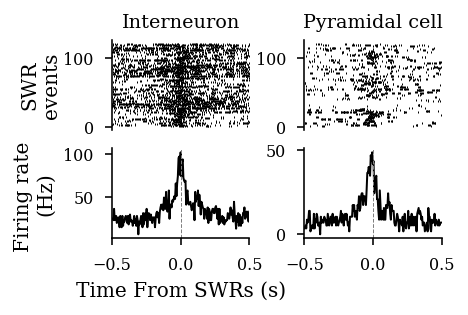

In [502]:
def swr_modulation(spikes,peak_time,binsize=0.005):
    # create raster centered over each ripple with a 1 second window
    x = []
    y = []
    for i,r in enumerate(peak_time):
        idx = (spikes> r - .5) & (spikes < r + .5)
        cur_spks = spikes[idx]
        if any(cur_spks):
            x.append(cur_spks - r)
            y.append(np.ones_like(cur_spks)+i)       
    x = list(itertools.chain(*x))
    y = list(itertools.chain(*y))

    # bin cell into 5ms bins 
    h0, bin_edges = np.histogram(x, bins=np.arange(-0.5,0.5,binsize))
    # normalize into firing rate
    h0 = h0 / (len(np.unique(y))*binsize)
    # smooth to get expected firing rate
    hist_smooth = gaussian_filter1d(h0,30)
    # subtract the expected rates and devided by the standard deviation to get z-scored modulation
    z = (h0 - hist_smooth) / np.sqrt(hist_smooth)
    # Calculate the amplitude of the SWR modulation
    swr_energy = np.sqrt(sum(z**2))
    return h0, z, swr_energy, x, y

cell_n = 6
# display(df_cell_class[df_cell_class.session == session].iloc[cell_n])

# loop through each cell and get modulation 
hist, z_hist, swr_energy, x, y = swr_modulation(spikes[cell_n],peak_time)

fig, axs = plt.subplots(2,2, figsize=set_size('thesis', fraction=.5, subplots=(2,2)), edgecolor='k')
fig.subplots_adjust(hspace = 0.2, wspace=0.4)
axs = axs.ravel()

axs[0].plot(x,y,'|',color='black',markersize=1,mew = 0.5,rasterized=True)
axs[0].set_ylabel("SWR\nevents",  multialignment='center',  labelpad = 1)
axs[0].set_xticks([], [])
axs[0].spines['top'].set_visible(False)
axs[0].spines['right'].set_visible(False)
axs[0].spines['bottom'].set_visible(False)
axs[0].get_xaxis().tick_bottom()
axs[0].get_yaxis().tick_left()
axs[0].set_xlim(-.5,.5)
axs[0].set_title('Interneuron')

axs[2].plot(np.linspace(-0.5,0.5,len(hist)), hist, color='black',linewidth = 1)
axs[2].set_ylabel('Firing rate \n(Hz)', verticalalignment = 'bottom')
axs[2].axvline(0,linestyle = '--', color = 'grey', linewidth = 0.5)
axs[2].spines['top'].set_visible(False)
axs[2].spines['right'].set_visible(False)
axs[2].get_xaxis().tick_bottom()
axs[2].get_yaxis().tick_left()
axs[2].set_xlim(-.5,.5)
axs[2].set_xlabel('Time From SWRs (s)')


cell_n = 2
# display(df_cell_class[df_cell_class.session == session].iloc[cell_n])

# loop through each cell and get modulation 
hist, z_hist, swr_energy, x, y = swr_modulation(spikes[cell_n],peak_time)

axs[1].plot(x,y,'|',color='black',markersize=1,mew = 0.5,rasterized=True)
# axs[1].set_ylabel("SWR\nevents",  multialignment='center',  labelpad = 1)
axs[1].set_xticks([], [])
axs[1].spines['top'].set_visible(False)
axs[1].spines['right'].set_visible(False)
axs[1].spines['bottom'].set_visible(False)
axs[1].get_xaxis().tick_bottom()
axs[1].get_yaxis().tick_left()
axs[1].set_xlim(-.5,.5)
axs[1].set_title('Pyramidal cell')


axs[3].plot(np.linspace(-0.5,0.5,len(hist)), hist, color='black',linewidth = 1)
# axs[3].set_ylabel('Firing rate (Hz)', verticalalignment = 'bottom')
axs[3].axvline(0,linestyle = '--', color = 'grey', linewidth = 0.5)
axs[3].spines['top'].set_visible(False)
axs[3].spines['right'].set_visible(False)
axs[3].get_xaxis().tick_bottom()
axs[3].get_yaxis().tick_left()
axs[3].set_xlim(-.5,.5)
# axs[3].set_xlabel('Time From SWRs (s)')

# plt.savefig(r'D:\ryanh\GoogleDrive\school_work\UNM\Lab\Projects\Dissertation\dissertation\inkscape_figs\ripple_section\mod_example_fig_int.svg',dpi=900,bbox_inches='tight')

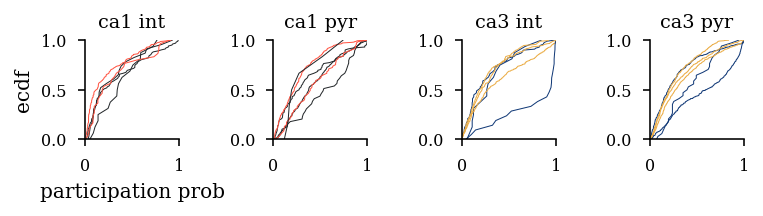

In [36]:
group_colors = {"controlca1": '#222629ff',
                "controlca3": '#103876ff',
                'paeca1': '#ff5240ff',
                'paeca3': '#ebad46ff'} 
def ecdf(x):
    xs = np.sort(x)
    ys = np.linspace(0,1,len(xs))
    return xs, ys


def plot_ecdf(var,df,area,ax,group_colors):
    for rat in pd.unique(df.rat):
        y = df[(df.rat == rat) & (df.area == area)]
        if y.empty == False:
            xs, ys = ecdf(y[var])
            ax.plot(xs,ys,color=group_colors[y.group.iloc[0]+y.area.iloc[0]],linewidth=.5)

            
fig, axs = plt.subplots(1,4, figsize=set_size('thesis', fraction=1, subplots=(1, 4)), edgecolor='k')
fig.subplots_adjust(hspace = 0, wspace=1)
axs = axs.ravel()

idx = ((df_cell_class.n_ripples >= 50) &
       (df_cell_class.n_spikes >= 100) &
       (df_cell_class.cell_type == "int"))

plot_ecdf('participation_prob',df_cell_class[idx],'ca1',axs[0],group_colors)
axs[0].set_xlim(0,1)
axs[0].set_ylim(0,1)
axs[0].set_xlabel('participation prob')
axs[0].set_ylabel('ecdf')
axs[0].set_title('ca1 int')

idx = ((df_cell_class.n_ripples >= 50) &
       (df_cell_class.n_spikes >= 100) &
       (df_cell_class.cell_type == "pyr"))

plot_ecdf('participation_prob',df_cell_class[idx],'ca1',axs[1],group_colors)
axs[1].set_xlim(0,1)
axs[1].set_ylim(0,1)
# axs[1].set_xlabel('participation prob')
axs[1].set_title('ca1 pyr')


idx = ((df_cell_class.n_ripples >= 50) &
       (df_cell_class.n_spikes >= 100) &
       (df_cell_class.cell_type == "int"))

plot_ecdf('participation_prob',df_cell_class[idx],'ca3',axs[2],group_colors)
axs[2].set_xlim(0,1)
axs[2].set_ylim(0,1)
# axs[2].set_xlabel('participation prob')
axs[2].set_title('ca3 int')

idx = ((df_cell_class.n_ripples >= 50) &
       (df_cell_class.n_spikes >= 100) &
       (df_cell_class.cell_type == "pyr"))

plot_ecdf('participation_prob',df_cell_class[idx],'ca3',axs[3],group_colors)
axs[3].set_xlim(0,1)
axs[3].set_ylim(0,1)
# axs[3].set_xlabel('participation prob')
axs[3].set_title('ca3 pyr')

for i in range(4):
    right_side = axs[i].spines["right"]
    right_side.set_visible(False)
    top_side = axs[i].spines["top"]
    top_side.set_visible(False)
    
save_path = "D:/ryanh/GoogleDrive/school_work/UNM/Lab/Projects/Dissertation/dissertation/inkscape_figs/ripple_recuitment/"
plt.savefig(save_path+'participation_prob.svg',dpi=300,bbox_inches='tight')
# plt.savefig(save_path+'ripple_features_cdf_ca1.png',dpi=300,bbox_inches='tight')

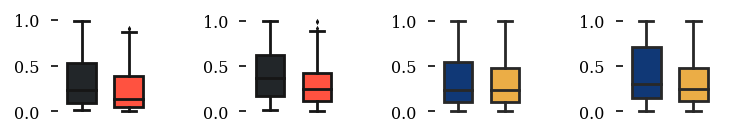

In [37]:
# Set your custom color palette

fig, axs = plt.subplots(1,4, figsize=set_size('thesis', fraction=1, subplots=(1, 4)), edgecolor='k')
fig.subplots_adjust(hspace = 0, wspace=1)
axs = axs.ravel()

idx = ((df_cell_class.n_ripples >= 50) &
       (df_cell_class.n_spikes >= 100) &
       (df_cell_class.cell_type == "int"))

sns.set_palette(sns.color_palette([group_colors['controlca1'],group_colors['paeca1']]))
g=sns.boxplot(x="group", y="participation_prob", data=df_cell_class[(df_cell_class.area=='ca1') & idx],
            width=.6,ax=axs[0],saturation=1,fliersize=.5)
axs[0].axes.get_xaxis().set_ticks([])
g.set(xlabel=None)
g.set(ylabel=None)

idx = ((df_cell_class.n_ripples >= 50) &
       (df_cell_class.n_spikes >= 100) &
       (df_cell_class.cell_type == "pyr"))

sns.set_palette(sns.color_palette([group_colors['controlca1'],group_colors['paeca1']]))
g=sns.boxplot(x="group", y="participation_prob", data=df_cell_class[(df_cell_class.area=='ca1') & idx],
            width=.6,ax=axs[1],saturation=1,fliersize=.5)
axs[1].axes.get_xaxis().set_ticks([])
g.set(xlabel=None)
g.set(ylabel=None)


idx = ((df_cell_class.n_ripples >= 50) &
       (df_cell_class.n_spikes >= 100) &
       (df_cell_class.cell_type == "int"))

sns.set_palette(sns.color_palette([group_colors['controlca3'],group_colors['paeca3']]))
g=sns.boxplot(x="group", y="participation_prob", data=df_cell_class[(df_cell_class.area=='ca3') & idx],
            width=.6,ax=axs[2],saturation=1,fliersize=.5)
axs[2].axes.get_xaxis().set_ticks([])
g.set(xlabel=None)
g.set(ylabel=None)

idx = ((df_cell_class.n_ripples >= 50) &
       (df_cell_class.n_spikes >= 100) &
       (df_cell_class.cell_type == "pyr"))

sns.set_palette(sns.color_palette([group_colors['controlca3'],group_colors['paeca3']]))
g=sns.boxplot(x="group", y="participation_prob", data=df_cell_class[(df_cell_class.area=='ca3') & idx],
            width=.6,ax=axs[3],saturation=1,fliersize=.5)
axs[3].axes.get_xaxis().set_ticks([])
g.set(xlabel=None)
g.set(ylabel=None)

sns.despine(trim=True, left=True, bottom=True)

plt.savefig(save_path+'participation_prob_box.svg',dpi=300,bbox_inches='tight')


### modulation strength

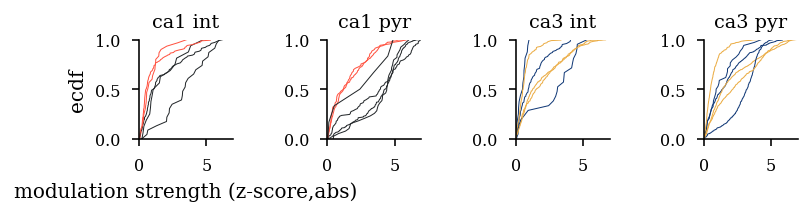

In [39]:

fig, axs = plt.subplots(1,4, figsize=set_size('thesis', fraction=1, subplots=(1, 4)), edgecolor='k')
fig.subplots_adjust(hspace = 0, wspace=1)
axs = axs.ravel()

idx = ((df_cell_class.n_ripples >= 50) &
       (df_cell_class.n_spikes >= 100) &
       (df_cell_class.cell_type == "int"))

plot_ecdf('mod_strength',df_cell_class[idx],'ca1',axs[0],group_colors)
axs[0].set_xlabel('modulation strength (z-score,abs)')
axs[0].set_ylabel('ecdf')
axs[0].set_title('ca1 int')

idx = ((df_cell_class.n_ripples >= 50) &
       (df_cell_class.n_spikes >= 100) &
       (df_cell_class.cell_type == "pyr"))

plot_ecdf('mod_strength',df_cell_class[idx],'ca1',axs[1],group_colors)
axs[1].set_title('ca1 pyr')


idx = ((df_cell_class.n_ripples >= 50) &
       (df_cell_class.n_spikes >= 100) &
       (df_cell_class.cell_type == "int"))

plot_ecdf('mod_strength',df_cell_class[idx],'ca3',axs[2],group_colors)
axs[2].set_title('ca3 int')

idx = ((df_cell_class.n_ripples >= 50) &
       (df_cell_class.n_spikes >= 100) &
       (df_cell_class.cell_type == "pyr"))

plot_ecdf('mod_strength',df_cell_class[idx],'ca3',axs[3],group_colors)
axs[3].set_title('ca3 pyr')

for i in range(4):
    right_side = axs[i].spines["right"]
    right_side.set_visible(False)
    top_side = axs[i].spines["top"]
    top_side.set_visible(False)
    
axs[0].set_xlim(0,7)
axs[1].set_xlim(0,7)
axs[2].set_xlim(0,7)
axs[3].set_xlim(0,7)

axs[0].set_ylim(0,1)
axs[1].set_ylim(0,1)
axs[2].set_ylim(0,1)
axs[3].set_ylim(0,1)


save_path = "D:/ryanh/GoogleDrive/school_work/UNM/Lab/Projects/Dissertation/dissertation/inkscape_figs/ripple_recuitment/"
plt.savefig(save_path+'mod_strength.svg',dpi=300,bbox_inches='tight')

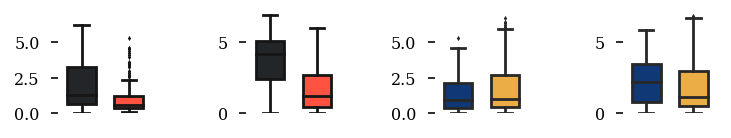

In [40]:
import math
def log_y_axis(ax,y,round_n=2,n_steps=5):
    """
    function to space Y axis in log scale without logging y values
    """
    y_log = np.linspace(math.floor(min(y)),math.ceil(max(y)),n_steps)
    ax.set_yticks(y_log)
    ax.set_yticklabels(np.round(10**y_log,round_n))
    
df_cell_class['mod_strength_log'] = np.log10(df_cell_class.mod_strength)


fig, axs = plt.subplots(1,4, figsize=set_size('thesis', fraction=1, subplots=(1, 4)), edgecolor='k')
fig.subplots_adjust(hspace = 0, wspace=1)
axs = axs.ravel()

idx = ((df_cell_class.n_ripples >= 50) &
       (df_cell_class.n_spikes >= 100) &
       (df_cell_class.cell_type == "int"))

sns.set_palette(sns.color_palette([group_colors['controlca1'],group_colors['paeca1']]))
g=sns.boxplot(x="group", y="mod_strength", data=df_cell_class[(df_cell_class.area=='ca1') & idx],
            width=.6,ax=axs[0],saturation=1,fliersize=.5)
axs[0].axes.get_xaxis().set_ticks([])

g.set(xlabel=None)
g.set(ylabel=None)

idx = ((df_cell_class.n_ripples >= 50) &
       (df_cell_class.n_spikes >= 100) &
       (df_cell_class.cell_type == "pyr"))

sns.set_palette(sns.color_palette([group_colors['controlca1'],group_colors['paeca1']]))
g=sns.boxplot(x="group", y="mod_strength", data=df_cell_class[(df_cell_class.area=='ca1') & idx],
            width=.6,ax=axs[1],saturation=1,fliersize=.5)
axs[1].axes.get_xaxis().set_ticks([])
g.set(xlabel=None)
g.set(ylabel=None)


idx = ((df_cell_class.n_ripples >= 50) &
       (df_cell_class.n_spikes >= 100) &
       (df_cell_class.cell_type == "int"))

sns.set_palette(sns.color_palette([group_colors['controlca3'],group_colors['paeca3']]))
g=sns.boxplot(x="group", y="mod_strength", data=df_cell_class[(df_cell_class.area=='ca3') & idx],
            width=.6,ax=axs[2],saturation=1,fliersize=.5)
axs[2].axes.get_xaxis().set_ticks([])
g.set(xlabel=None)
g.set(ylabel=None)

idx = ((df_cell_class.n_ripples >= 50) &
       (df_cell_class.n_spikes >= 100) &
       (df_cell_class.cell_type == "pyr"))

sns.set_palette(sns.color_palette([group_colors['controlca3'],group_colors['paeca3']]))
g=sns.boxplot(x="group", y="mod_strength", data=df_cell_class[(df_cell_class.area=='ca3') & idx],
            width=.6,ax=axs[3],saturation=1,fliersize=.5)
axs[3].axes.get_xaxis().set_ticks([])
g.set(xlabel=None)
g.set(ylabel=None)

sns.despine(trim=True, left=True, bottom=True)

axs[0].set_ylim(0,7)
axs[1].set_ylim(0,7)
axs[2].set_ylim(0,7)
axs[3].set_ylim(0,7)

plt.savefig(save_path+'mod_strength_box.svg',dpi=300,bbox_inches='tight')


### baseline firing rates

-2.4890451337431174

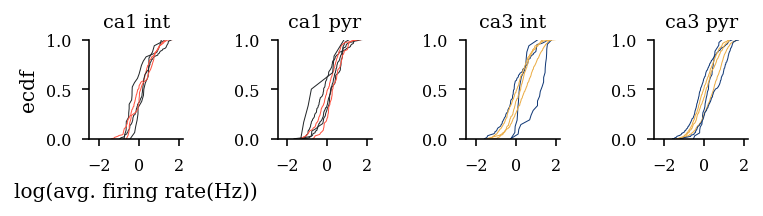

In [105]:
fig, axs = plt.subplots(1,4, figsize=set_size('thesis', fraction=1, subplots=(1, 4)), edgecolor='k')
fig.subplots_adjust(hspace = 0, wspace=1)
axs = axs.ravel()

df_cell_class['avg_fr_log'] = np.log10(df_cell_class.avg_fr)

idx = ((df_cell_class.n_ripples >= 50) &
       (df_cell_class.n_spikes >= 100) &
       (df_cell_class.cell_type == "int"))

plot_ecdf('avg_fr_log',df_cell_class[idx],'ca1',axs[0],group_colors)
axs[0].set_xlabel('log(avg. firing rate(Hz))')
axs[0].set_ylabel('ecdf')
axs[0].set_title('ca1 int')

idx = ((df_cell_class.n_ripples >= 50) &
       (df_cell_class.n_spikes >= 100) &
       (df_cell_class.cell_type == "pyr"))

plot_ecdf('avg_fr_log',df_cell_class[idx],'ca1',axs[1],group_colors)
axs[1].set_title('ca1 pyr')


idx = ((df_cell_class.n_ripples >= 50) &
       (df_cell_class.n_spikes >= 100) &
       (df_cell_class.cell_type == "int"))

plot_ecdf('avg_fr_log',df_cell_class[idx],'ca3',axs[2],group_colors)
axs[2].set_title('ca3 int')

idx = ((df_cell_class.n_ripples >= 50) &
       (df_cell_class.n_spikes >= 100) &
       (df_cell_class.cell_type == "pyr"))

plot_ecdf('avg_fr_log',df_cell_class[idx],'ca3',axs[3],group_colors)
axs[3].set_title('ca3 pyr')

for i in range(4):
    right_side = axs[i].spines["right"]
    right_side.set_visible(False)
    top_side = axs[i].spines["top"]
    top_side.set_visible(False)
    
axs[0].set_xlim(min(df_cell_class.avg_fr_log),max(df_cell_class.avg_fr_log))
axs[1].set_xlim(min(df_cell_class.avg_fr_log),max(df_cell_class.avg_fr_log))
axs[2].set_xlim(min(df_cell_class.avg_fr_log),max(df_cell_class.avg_fr_log))
axs[3].set_xlim(min(df_cell_class.avg_fr_log),max(df_cell_class.avg_fr_log))


axs[0].set_ylim(0,1)
axs[1].set_ylim(0,1)
axs[2].set_ylim(0,1)
axs[3].set_ylim(0,1)


save_path = "D:/ryanh/GoogleDrive/school_work/UNM/Lab/Projects/Dissertation/dissertation/inkscape_figs/ripple_recuitment/"
plt.savefig(save_path+'avg_fr_log.svg',dpi=300,bbox_inches='tight')

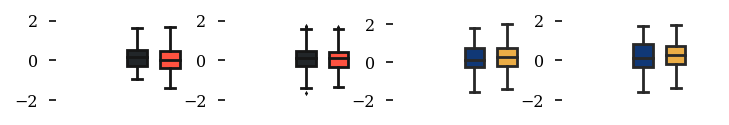

In [113]:
fig, axs = plt.subplots(1,4, figsize=set_size('thesis', fraction=1, subplots=(1, 5)), edgecolor='k')
fig.subplots_adjust(hspace = 0, wspace=.1)
axs = axs.ravel()

idx = ((df_cell_class.n_ripples >= 50) &
       (df_cell_class.n_spikes >= 100) &
       (df_cell_class.cell_type == "int"))

sns.set_palette(sns.color_palette([group_colors['controlca1'],group_colors['paeca1']]))
g=sns.boxplot(x="group", y="avg_fr_log", data=df_cell_class[(df_cell_class.area=='ca1') & idx],
            width=.6,ax=axs[0],saturation=1,fliersize=.5)
axs[0].axes.get_xaxis().set_ticks([])

g.set(xlabel=None)
g.set(ylabel=None)

idx = ((df_cell_class.n_ripples >= 50) &
       (df_cell_class.n_spikes >= 100) &
       (df_cell_class.cell_type == "pyr"))

sns.set_palette(sns.color_palette([group_colors['controlca1'],group_colors['paeca1']]))
g=sns.boxplot(x="group", y="avg_fr_log", data=df_cell_class[(df_cell_class.area=='ca1') & idx],
            width=.6,ax=axs[1],saturation=1,fliersize=.5)
axs[1].axes.get_xaxis().set_ticks([])
g.set(xlabel=None)
g.set(ylabel=None)


idx = ((df_cell_class.n_ripples >= 50) &
       (df_cell_class.n_spikes >= 100) &
       (df_cell_class.cell_type == "int"))

sns.set_palette(sns.color_palette([group_colors['controlca3'],group_colors['paeca3']]))
g=sns.boxplot(x="group", y="avg_fr_log", data=df_cell_class[(df_cell_class.area=='ca3') & idx],
            width=.6,ax=axs[2],saturation=1,fliersize=.5)
axs[2].axes.get_xaxis().set_ticks([])
g.set(xlabel=None)
g.set(ylabel=None)

idx = ((df_cell_class.n_ripples >= 50) &
       (df_cell_class.n_spikes >= 100) &
       (df_cell_class.cell_type == "pyr"))

sns.set_palette(sns.color_palette([group_colors['controlca3'],group_colors['paeca3']]))
g=sns.boxplot(x="group", y="avg_fr_log", data=df_cell_class[(df_cell_class.area=='ca3') & idx],
            width=.6,ax=axs[3],saturation=1,fliersize=.5)
axs[3].axes.get_xaxis().set_ticks([])
g.set(xlabel=None)
g.set(ylabel=None)

sns.despine(trim=True, left=True, bottom=True)

axs[0].set_xlim(min(df_cell_class.avg_fr_log),max(df_cell_class.avg_fr_log))
axs[1].set_xlim(min(df_cell_class.avg_fr_log),max(df_cell_class.avg_fr_log))
axs[2].set_xlim(min(df_cell_class.avg_fr_log),max(df_cell_class.avg_fr_log))
axs[3].set_xlim(min(df_cell_class.avg_fr_log),max(df_cell_class.avg_fr_log))

axs[0].set_yticks([int(min(df_cell_class.avg_fr_log)),0,int(max(df_cell_class.avg_fr_log))])
axs[1].set_yticks([int(min(df_cell_class.avg_fr_log)),0,int(max(df_cell_class.avg_fr_log))])
axs[2].set_yticks([int(min(df_cell_class.avg_fr_log)),0,int(max(df_cell_class.avg_fr_log))])
axs[3].set_yticks([int(min(df_cell_class.avg_fr_log)),0,int(max(df_cell_class.avg_fr_log))])

plt.savefig(save_path+'avg_fr_log_box.svg',dpi=300,bbox_inches='tight')


In [108]:
pd.unique(df_cell_class.group)

array(['control', 'pae'], dtype=object)